# Applying MLOPS principles to develop a Text Classification Model

Last updated : 6th January 2023

## Introduction

The goal of this project is to develop a Project Classification Model using production grade MLOPS practices. 

In this notebook, I will develop a supervised machine learning (classification) model using a simple vectorization algorithm (TF-IDF).

This model could be improved by using BERT Embeddings and a higher-end deep learning model.

After developing this baseline model, I will optimize it using experiment tracking modules before switching to Python scripts for the development and deployment of more advanced alternatives.


## 1 Data Loading and Analysis

### 1.1 ETL

In [4]:
import pandas as pd
# Loading projects"
projects = pd.read_csv("https://raw.githubusercontent.com/Faskill/MLOps-Text-Classification/main/Data/projects.csv")
projects.head(5)

,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [5]:
# Loading tags
tags = pd.read_csv("https://raw.githubusercontent.com/Faskill/MLOps-Text-Classification/main/Data/tags.csv")
tags.head(5)

,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


In [6]:
# Merging projects and tags
df = pd.merge(projects, tags, on="id", how = "outer")
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [7]:
# Removing projects without a tag
df = df[df.tag.notnull()]
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [8]:
# Saving data locally
df.to_csv("labeled_projects.csv", index=False)

### 1.2 Exploratory Data Analysis (EDA)

In [9]:
# Counting the number of tags of each category
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
mlops                           79
reinforcement-learning          56
graph-learning                  45
time-series                     31
Name: tag, dtype: int64

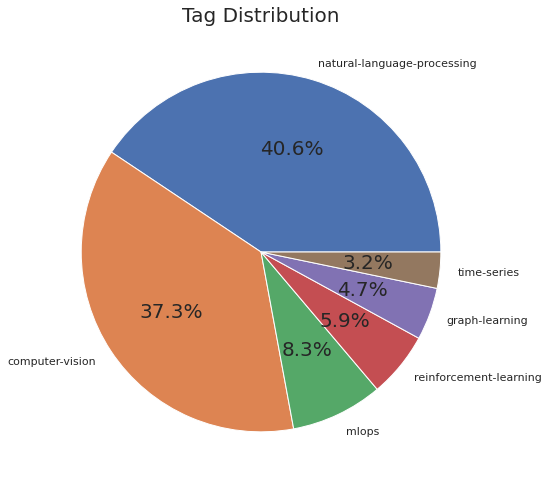

In [10]:
#Creating a pie chart of the tags
import matplotlib.pyplot as plt
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

vc = df.tag.value_counts()
plt.pie(vc, labels = vc.index,autopct='%1.1f%%')
plt.title('Tag Distribution')
plt.show()

In [11]:
# Calculating title and description length
df['title_length'] = df['title'].apply(len)
df['desc_length'] = df['description'].apply(len)

df.head()

,id,created_on,title,description,tag,title_length,desc_length
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,53,107
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,64,147
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning,28,114
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning,19,89


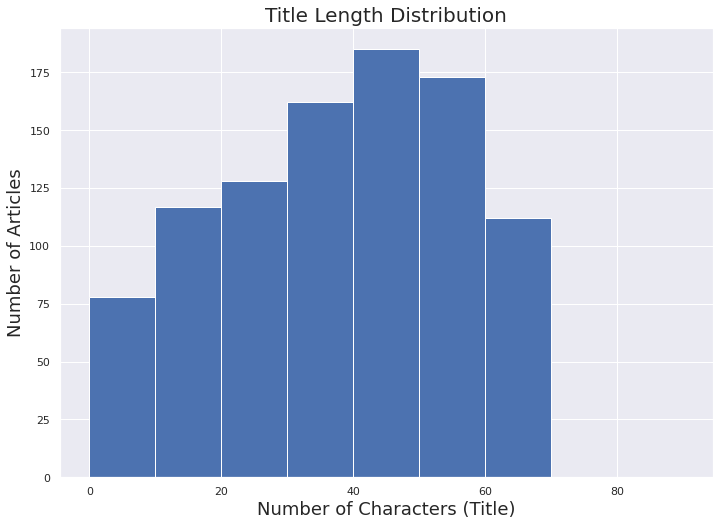

In [12]:
#Histogram of title length
plt.hist(df['title_length'], bins = range(0,100,10))
plt.title('Title Length Distribution')
plt.xlabel('Number of Characters (Title)')
plt.ylabel('Number of Articles')
plt.show()

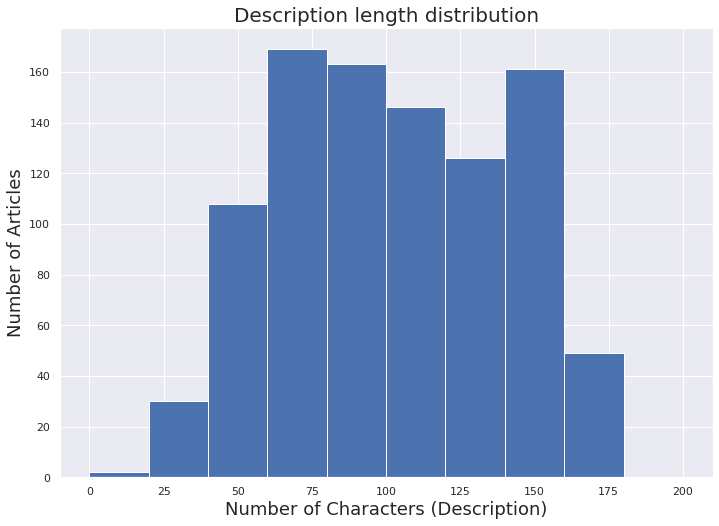

In [13]:
#Histogram of description length
plt.hist(df['desc_length'], bins = range(0,220,20))
plt.title('Description length distribution')
plt.xlabel('Number of Characters (Description)')
plt.ylabel('Number of Articles')
plt.show()

In [14]:
#Let's investigate the outliers with a description below 25 characters
df[df.desc_length < 25]

,id,created_on,title,description,tag,title_length,desc_length
29,108,2020-03-21 23:17:38,Tuned ALBERT (ensemble model),Top 6 in Squad 2.0,natural-language-processing,29,18
341,880,2020-05-16 11:50:31,How Deep Is Your Love For Transfer Learning In...,A review of NLP research,natural-language-processing,51,24
536,1480,2020-06-16 23:06:13,A Guide to Natural Language Processing With Al...,basics of using AllenNLP,natural-language-processing,52,24
695,1856,2020-07-14 03:21:00,DeepDream Video Style Transfer,DeepDream on Video,computer-vision,30,18
737,1934,2020-07-21 01:47:01,Graphein,Protein Graph Library,graph-learning,8,21
747,1954,2020-07-24 06:43:59,Azure ML,MLOps using Azure ML.,mlops,8,21
942,2417,2020-10-02 09:44:25,Parallelizing Prophet Cross-Validation with Dask,Applied Example w/ Code,time-series,48,23


It seems like most projects with short description are pretty easy to classify because they have keywords either in the title or in the description, so we won't remove them from our database.

In [15]:
df['tag'].unique()

array(['computer-vision', 'graph-learning', 'reinforcement-learning',
       'natural-language-processing', 'mlops', 'time-series'],
      dtype=object)

In [16]:
# Looking at important words for each tags
from wordcloud import WordCloud, STOPWORDS
import ipywidgets as widgets

# Most frequent tokens for each tag
@widgets.interact(tag=df['tag'].unique())
def display_word_cloud(tag="natural-language-processing"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)
    plt.show()

interactive(children=(Dropdown(description='tag', index=3, options=('computer-vision', 'graph-learning', 'rein…

## 2 Data Preprocessing


### 2.1 Feature engineering

The feature engineering process will be very short in that case because we're only going to analyze text data in that case.

In [17]:
# Merging all text data
df['text'] = df['title'] + ' ' + df['description']
df.head()

,id,created_on,title,description,tag,title_length,desc_length,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,53,107,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,64,147,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning,28,114,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning,19,89,Diffusion to Vector Reference implementation o...


### 2.1 Text Data Preprocessing

First we will preprocess our text data. In line with the goal of this project, which is to create a quick version of our model, we will use nltk to be able to use stemming if necessary. 

In a production environment, a good (and quicker) alternative would be SpaCy to be able to use lemmatization.

In [18]:
!pip install nltk==3.7 -q
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [19]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
# Creating a function to preprocess text data
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower:
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

In [21]:
# Apply to dataframe
df['cleaned_text'] = df.text.apply(clean_text, lower=True, stem=False)
print (f"{df.text.values[0]}\n{df.cleaned_text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### 2.2 Handling out of scope (OOS) tags

Since we are using a data set with a limited sample size, we will replace tags with too few samples with a "other" category.

In [22]:
import json
#List of accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

#Out of scope (OOS) tags
oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
oos_tags

['reinforcement-learning', 'time-series']

In [23]:
# Samples with OOS tags
oos_indices = df[df.tag.isin(oos_tags)].index
df[df.tag.isin(oos_tags)].head()

,id,created_on,title,description,tag,title_length,desc_length,text,cleaned_text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71,Awesome Monte Carlo Tree Search A curated list...,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,reinforcement-learning,42,147,Deep Reinforcement Learning in TensorFlow2 dee...,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,reinforcement-learning,35,95,Distributional RL using TensorFlow2 🐳 Implemen...,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,time-series,29,126,Prophet: Forecasting At Scale Tool for produci...,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,reinforcement-learning,37,100,Curriculum for Reinforcement Learning Curricul...,curriculum reinforcement learning curriculum l...


In [24]:
# Replacing this tag with "other"
df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)
df.iloc[oos_indices].head()

,id,created_on,title,description,tag,title_length,desc_length,text,cleaned_text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,31,71,Awesome Monte Carlo Tree Search A curated list...,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,other,42,147,Deep Reinforcement Learning in TensorFlow2 dee...,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,other,35,95,Distributional RL using TensorFlow2 🐳 Implemen...,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,other,29,126,Prophet: Forecasting At Scale Tool for produci...,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,other,37,100,Curriculum for Reinforcement Learning Curricul...,curriculum reinforcement learning curriculum l...


In [25]:
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
other                           87
mlops                           79
graph-learning                  45
Name: tag, dtype: int64

In [26]:
#Not enough data to identify the graph learning topics (we set a threshold at 75)
#We will join this category with our "other" category
def filter_tags(tag, exclude=[]):
  if tag in exclude:
    tag = None
  return tag

df.tag = df.tag.apply(filter_tags, exclude = ['graph-learning'])

df.tag = df.tag.fillna("other")
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
other                          132
mlops                           79
Name: tag, dtype: int64

In [27]:
import numpy as np
import random


# Get data
X = df.cleaned_text.to_numpy()
y = df.tag

### 2.3 Categorical Data Encoding

In this part, we will define our own label encoding function as an example that can be customized to our needs. 

A quicker alternative would be to monkey-patch sklearn's native function.

In [28]:
#Defining custom LabelEncoder

class LabelEncoder(object):
    """Encode labels into unique indices"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [29]:
# Encoding
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

num_classes

4

In [30]:
label_encoder.class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [31]:
label_encoder.index_to_class

{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [32]:
#Testing encoder
label_encoder.encode(["computer-vision", "mlops", "mlops"])

array([0, 1, 1])

In [33]:
# Decode
label_encoder.decode(np.array([0, 1, 1]))

['computer-vision', 'mlops', 'mlops']

In [34]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(955,)


In [35]:
from sklearn.model_selection import train_test_split
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [36]:
# Creating train/test split
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 668 (0.70)
remaining: 287 (0.30)


In [37]:
# Creating test/val split
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)

print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [38]:
# Retrieving counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}

# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [39]:
# Adjusting counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))
  
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,247,56,270,93
test,252,56,270,93


We can see that our test/train split are quite balanced.
Let's calculate the standard deviation :

In [40]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

0.9851056877051131

This deviation is moderate, which means that there is some imbalance in our classes.

In [41]:
# Example of code for multi-label classification
!pip install scikit-multilearn
from skmultilearn.model_selection import IterativeStratification
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 3.5 MB/s eta 0:00:00


In [42]:
# Creating split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,nlp viewer simple website browsing popular nlp...,natural-language-processing
1,converting images tf records colab notebook sh...,computer-vision
2,attributed social network embedding sparsity a...,other
3,leveraging temporal context object detection o...,computer-vision
4,face mask detector simple streamlit frontend f...,computer-vision


### 2.4 Data Augmentation

In this part, we will implement a data augmentation policy for text data.

In [117]:
# Loagind nlpaug and snorkel

!pip install nlpaug==1.1.0 transformers==3.0.2 -q
!pip install snorkel==0.9.8 -q

import nlpaug.augmenter.word as naw

In [44]:
# Loading tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")
text = "Conditional image generation using Variational Autoencoders and GANs."

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [45]:
# Substitutions
substitution.augment(text)

'adaptive image editing in variational autoencoders used gans.'

Substitutions do not seem like a very good idea because they remove keywords like GAN here.


In [46]:
# Insertions
insertion.augment(text)

'• conditional digital image signal generation using variational digital autoencoders and gans.'

The problem is now that there is a risk that keywords will get inserted into our text samples.

In [47]:
# Replace dashes from tags & aliases
def replace_dash(x):
    return x.replace("-", " ")

# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

print (flattened_aliases["natural language processing"])
print (flattened_aliases["nlp"])

['nlp', 'nlproc']
['nlproc', 'natural language processing']


In [48]:
flattened_aliases

{'computer vision': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'mlops': ['production'],
 'production': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing']}

In [49]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")

True
True


In [50]:
# Creating word finding function
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

<re.Match object; span=(10, 13), match='gan'>
None


In [51]:
# Using the inflect package to add plurals to our aliases

!pip install inflect
import inflect

p = inflect.engine()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
inflected_aliases = {}

for _tag, _alias in flattened_aliases.items():
    inflected_aliases[_tag] = _alias
    inflected_aliases[p.plural(_tag)] = _alias

inflected_aliases

{'computer vision': ['cv', 'vision'],
 'computer visions': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'cvs': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'visions': ['cv', 'computer vision'],
 'mlops': ['production'],
 'mlop': ['production'],
 'production': ['mlops'],
 'productions': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'natural language processings': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlps': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing'],
 'nlprocs': ['nlp', 'natural language processing']}

In [53]:
#Using snorkel's transformations to apply this modification to our data
from snorkel.augmentation import transformation_function

@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases."""
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(inflected_aliases[tag])}{x.text[match.end():]}"
    return x

In [54]:
# Swap
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning nlproc tasks
survey reinforcement learning nlproc tasks
survey reinforcement learning nlproc tasks


In [55]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate cv apply jobs using nlproc
autogenerate cv apply jobs using natural language processing
autogenerate computer vision apply jobs using nlp


We consider that there is a low likelihood that ML accronyms will be used for other uses, as in the example above.

In [56]:
# Defining an Augmentation Policy
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier


# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 668/668 [00:02<00:00, 263.82it/s]


,text,tag
0,nlp viewer simple website browsing popular nlp...,natural-language-processing
0,nlproc viewer simple website browsing popular ...,natural-language-processing
0,natural language processing viewer simple webs...,natural-language-processing
1,converting images tf records colab notebook sh...,computer-vision
2,attributed social network embedding sparsity a...,other


In [57]:
len(train_df), len(train_df_augmented)

(668, 898)

This Data Augmentation example was a draft implementation that we will not use in the rest of this notebook, as this would require a lot of oversight to ensure that we don't loose important information. 

We will keep this in mind for the actual implementation of our model later on.

## 3 Model development and training

### 3.1 Baseline Model 1 : Random

First we will implement a very simple baseline model that will decide tags at random.

In [58]:
# Modeling, first we will implement a random algorithm
from collections import Counter
import random

def set_seeds(seed=42):
  #Set seeds for reproducibility
  np.random.seed(seed)
  random.seed(seed)

def preprocess(df, lower, stem, min_freq):
  df["text"] = df.title + " " + df.description # Feature engineering
  df.text = df.text.apply(clean_text, lower=lower, stem = stem) #Clean text

  #Replace OOS tags with 'other'
  oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
  df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

  #Replace tags below min_freq with 'other'
  tags = Counter(df.tag.values)
  tags_above_freq = Counter(tag for tag in tags.elements()
                            if (tags[tag] >= min_freq))
  
  df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
  df.tag = df.tag.fillna("other")

  return df


In [59]:
# Creating a function to quickly define test/train/val splits
def create_splits(X, y, train_size = 0.7):
  """Generate balanced data splits"""
  X_train, X_, y_train, y_ = train_test_split(
      X, y, train_size=train_size, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(
      X_, y_, train_size=0.5, stratify=y_)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [60]:
# Importing metrics
from sklearn.metrics import precision_recall_fscore_support

In [61]:
#Initializing our data
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

#Label encoder verification
print(label_encoder)
print(label_encoder.classes)

<LabelEncoder(num_classes=4)>
['computer-vision', 'mlops', 'natural-language-processing', 'other']


In [62]:
#Generating random predictions
y_pred = np.random.randint(low=0, high = len(label_encoder), size=len(y_test))
print(y_pred.shape)
print(y_pred[0:5])

(144,)
[2 2 1 3 3]


In [63]:
#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.2844744487889649, 'recall': 0.22916666666666666, 'f1': 0.24552884283001275}


We can see that the **performance of this random model is very low**, with a f1 score at 0.245.

### 3.2 Baseline Model 2 : class probabilities

We will now use a bit more realistic baseline model that will take into account the class probabilities in our dataset.

In [64]:
#Using the train split to apply realistic class probabilities
#Class frequencies 
p = [Counter(y_test)[index]/len(y_test) for index in range(len(label_encoder))]
p

[0.375, 0.08333333333333333, 0.4027777777777778, 0.1388888888888889]

In [65]:
#Generating weighted predictions
y_pred = np.random.choice(a=range(len(label_encoder)), size=len(y_test), p=p)

#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.3294211281499417, 'recall': 0.3194444444444444, 'f1': 0.3239553132352485}


This model has a slightly better, albeit still mediocre, performance with a f1 score at 0.32.

### 3.3 Baseline Model 3 : Rule based

This rule based baseline model will predict a category only if it finds keywords in the text. Otherwise it will predict -1.

In [66]:
#Rule based methodology 

#Initialization
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

In [67]:
#If a token matches an alias, then add the corresponding tag class
def get_tag(text, aliases_by_tag):
  for tag, aliases in aliases_by_tag.items():
    if replace_dash(tag) in text:
      return tag
    for alias in aliases:
      if alias in text:
        return tag
  return None

In [68]:
#Sample
text = "An excellent model for the best NLP models"

get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag)

'natural-language-processing'

In [69]:
#Prediction
tags = []
for text in X_test:
  tag = get_tag(text, aliases_by_tag=aliases_by_tag)
  tags.append(tag)

#Encoding labels
y_pred = [label_encoder.class_to_index[tag] if tag is not None else -1 for tag in tags]

#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.8611111111111112, 'recall': 0.1597222222222222, 'f1': 0.2600750175139683}


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  


In [70]:
# Pitfalls
text = "Transfer learning with transformers for text classification."
print (get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag))

None


### 3.4 Text Vectorization

We will use TF-IDF as a quick and dirty vectorization method in order to perform this Proof of Concept modelling.  

In [71]:
#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#Initialization
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

#Saving X_test to compare with later
X_test_raw = X_test

In [72]:
#TF-IDF
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7)) #Char n-grams 2-7
print(X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

print(X_train.shape)

laplacian pyramid reconstruction refinement semantic seg pytorch implementation multi resolution reconstruction architecture based laplacian pyramid uses skip connections
(668, 98496)


In [73]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i,count in enumerate(counts)}
print(f"class counts: {counts}, \n class weights: {class_weights}")

class counts: [249  55 272  92], 
 class weights: {0: 0.004016064257028112, 1: 0.01818181818181818, 2: 0.003676470588235294, 3: 0.010869565217391304}


### 3.5 Data resampling

In [74]:
# Data imbalance
!pip install imbalanced-learn==0.8.1 -q
from imblearn.over_sampling import RandomOverSampler

In [75]:
# Oversampling (training set)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [76]:
# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [272 272 272 272],
class weights: {0: 0.003676470588235294, 1: 0.003676470588235294, 2: 0.003676470588235294, 3: 0.003676470588235294}


### 3.6 Logistic Regression / SGD Classification

In [77]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

# Initializing model
#We're using a SGD Classifier with log loss
#This is very similar to a Log Regression with SGD

model = SGDClassifier(
loss="log", penalty="l2", alpha=1e-4, max_iter=100,
learning_rate="constant", eta0=1e-1, power_t=0.1,
warm_start=True)

In [78]:
# Model training
num_epochs = 100
for epoch in range(num_epochs+1):
  # Training
  model.fit(X_over, y_over)
  # Evaluation
  train_loss = log_loss(y_train, model.predict_proba(X_train))
  val_loss = log_loss(y_val, model.predict_proba(X_val))
  if not epoch%10:
    print(
      f"Epoch: {epoch:02d} | "
      f"train_loss: {train_loss:.5f}, "
      f"val_loss: {val_loss:.5f}"
    )

Epoch: 00 | train_loss: 0.20354, val_loss: 0.44303
Epoch: 10 | train_loss: 0.15648, val_loss: 0.41225
Epoch: 20 | train_loss: 0.14875, val_loss: 0.40816
Epoch: 30 | train_loss: 0.14596, val_loss: 0.40702
Epoch: 40 | train_loss: 0.14440, val_loss: 0.40636
Epoch: 50 | train_loss: 0.14313, val_loss: 0.40581
Epoch: 60 | train_loss: 0.14214, val_loss: 0.40540
Epoch: 70 | train_loss: 0.14134, val_loss: 0.40513
Epoch: 80 | train_loss: 0.14079, val_loss: 0.40494
Epoch: 90 | train_loss: 0.14020, val_loss: 0.40474
Epoch: 100 | train_loss: 0.13978, val_loss: 0.40455


In [79]:
# Evaluation
y_pred = model.predict(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred,
average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1":
metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8764647844565878,
  "recall": 0.875,
  "f1": 0.8737886461377173
}


In [80]:
# Testing (with tokens not similar to training data)
text = "Using text classification to predict the sentiment of Twitter posts"
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [81]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.07018529397337082,
 'mlops': 0.004552824383735391,
 'natural-language-processing': 0.8949149611229926,
 'other': 0.030346920519901184}

In [82]:
# Second test
text = "Using GAN to predict model behavior"
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [83]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.36066013050841494,
 'mlops': 0.045477797277782596,
 'natural-language-processing': 0.4430094358866647,
 'other': 0.15085263632713797}

It predicts nlp but the utterance clearly belonged to the "other" category. We will create a custom predict function to avoid this problem.

The custom predict function will take as a threshold the first quantile softmax score for the correct class.

We use the validation split to **avoid data leakage.**

### 3.7 Decision Thresholds

We will create a custom predict function that will assign the "other" class when the probability is below a certain threshold.

#### 3.7.1 Unique Threshold

In [84]:
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
threshold = np.quantile([y_prob[i][j] for i, j in enumerate(y_pred)],
q=0.25) # Q1
threshold

0.6841094257700038

It would be interesting to look at **class thresholds**, because those may significantly differ for each class.

#### 3.7.2 Class Thresholds

In [85]:
class_thresholds = {}
for c in range(len(label_encoder.classes)):
  class_thresholds[c] = np.quantile(
      [y_prob[i][c] for i in np.where(y_pred==c)[0]],
      q=0.25)
class_thresholds

{0: 0.6991101748903702,
 1: 0.6438804248079768,
 2: 0.6964953391485422,
 3: 0.5424208623945845}

In [86]:
class_thresholds[np.argmax(y_prob[1])]

0.6991101748903702

In [87]:
# Custom predict function
def custom_predict(y_prob, class_thresholds, index):
  """Custom predict function that defaults
  to an index if conditions are not met."""
  y_pred = [np.argmax(p) if max(p) > class_thresholds[np.argmax(p)] else index for p in
  y_prob]
  return np.array(y_pred)

In [88]:
def predict_tag(texts):
  y_prob = model.predict_proba(vectorizer.transform(texts))
  other_index = label_encoder.class_to_index["other"]
  y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
  index=other_index)
  return label_encoder.decode(y_pred)

In [89]:
# Testing (with tokens not similar to training data)
text = "Using GAN to predict model behavior"
predict_tag(texts=[text])

['other']

In [90]:
# Evaluation
y_prob = model.predict_proba(X_test)
other_index = label_encoder.class_to_index["other"]
y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
index=other_index)
metrics = precision_recall_fscore_support(y_test, y_pred,
average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1":
metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7852151881854853
}


In [91]:
#Metrics
metrics = {"overall": {}, "class": {}}

# Overall metrics
from sklearn.metrics import precision_recall_fscore_support

overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9032828282828282,
    "recall": 0.75,
    "f1": 0.7852151881854853,
    "num_samples": 144.0
}


In [92]:
# Fine-grained class specific metrics
from collections import OrderedDict

class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }


# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "natural-language-processing",
  {
    "precision": 1.0,
    "recall": 0.7413793103448276,
    "f1": 0.8514851485148515,
    "num_samples": 58.0
  }
]
[
  "mlops",
  {
    "precision": 0.9,
    "recall": 0.75,
    "f1": 0.8181818181818182,
    "num_samples": 12.0
  }
]
[
  "computer-vision",
  {
    "precision": 1.0,
    "recall": 0.6666666666666666,
    "f1": 0.8,
    "num_samples": 54.0
  }
]
[
  "other",
  {
    "precision": 0.36363636363636365,
    "recall": 1.0,
    "f1": 0.5333333333333333,
    "num_samples": 20.0
  }
]


In [93]:
# TP, FP, FN samples for mlops
tag = "mlops"
index = label_encoder.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [94]:
print (tp)
print (fp)
print (fn)

[0, 5, 47, 52, 96, 111, 123, 129, 141]
[114]
[38, 130, 136]


In [95]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"  {X_test_raw[index]}")
            print (f"    true: {label_encoder.decode([y_test[index]])[0]}")
            print (f"    pred: {label_encoder.decode([y_pred[index]])[0]}\n")


=== True positives ===
  pytest pytest framework makes easy write small tests yet scales support complex functional testing
    true: mlops
    pred: mlops

  test machine learning code systems minimal examples testing machine learning correct implementation expected learned behaviour model performance
    true: mlops
    pred: mlops

  continuous machine learning cml cml helps organize mlops infrastructure top traditional software engineering stack instead creating separate ai platforms
    true: mlops
    pred: mlops


=== False positives ===
  paint machine learning web app allows create landscape painting style bob ross using deep learning model served using spell model server
    true: computer-vision
    pred: mlops


=== False negatives ===
  hidden technical debt machine learning systems using software engineering framework technical debt find common incur massive ongoing maintenance costs real world ml systems
    true: mlops
    pred: other

  docker help become effective da

To sum up this part of the project, the implementation of class thresholds has **improved our precision, but diminished the f1 score**.

We will leave this within our pipeline for now and optimize it later in the hyperparameter setting part of the project.

We will now look into **Confident Learning** and we will use cleanlab to show how we could **identify noisy labels** that could be relabelled to improve the performance of our model.

### 3.8 Confident Learning

In [96]:
# Confident Learning
y_prob = model.predict_proba(X_test)
print (np.shape(y_test))
print (np.shape(y_prob))

(144,)
(144, 4)


In [97]:
# Used to show raw text
test_df = pd.DataFrame({"text": X_test_raw, "tag": label_encoder.decode(y_test)})

# Tag to inspect
tag = "mlops"
index = label_encoder.class_to_index[tag]
indices = np.where(y_test==index)[0]

# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({"text": test_df.text[i],
                               "true": label_encoder.index_to_class[y_test[i]],
                               "pred": label_encoder.index_to_class[y_pred[i]],
                               "prob": prob})

low_confidence[0:5]

[{'text': 'neptune ai lightweight experiment management tool fits workflow',
  'true': 'mlops',
  'pred': 'other',
  'prob': 0.3806817845628073}]

In [98]:
# Using cleanlab to identify noisy labels
!pip install cleanlab==1.0.1 -q
import cleanlab
from cleanlab.pruning import get_noise_indices

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 KB 3.4 MB/s eta 0:00:00


In [99]:
#Applying to test set
y_prob = model.predict_proba(X_test)
other_index = label_encoder.class_to_index["other"]
y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
index=other_index)


# Determine potential labeling errors
label_error_indices = get_noise_indices(
            s=y_test,
            psx=y_prob,
            sorted_index_method="self_confidence",
            verbose=0)


num_samples = 20
for index in label_error_indices[:num_samples]:
    print ("text:", test_df.iloc[index].text)
    print ("true:", test_df.iloc[index].tag)
    print ("pred:", label_encoder.decode([y_pred[index]])[0])
    print ()

text: module 2 convolutional neural networks cs231n lecture 5 move fully connected neural networks convolutional neural networks
true: computer-vision
pred: other

text: goturn pytorch pytorch implementation learning track 100 fps deep regression networks
true: computer-vision
pred: other



In [100]:
label_error_indices

array([140,  14])

We have detected **2 labels within our test set that have been identified as potential labelling errors**.
Both of these labels are good though, so it seems that we may need to upsample those kind of labels to improve the performance of our models.

### 3.9 Data Slicing

We will now try to look at **data slices** to try to identify if we have to focus on a particular slice in order to improve the performance of our model.

We will use the slicing functions implemented in the snorkel module.

In [101]:
#Defining slicing functions with snorkel
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

@slicing_function()
def nlp_cnn(x):
    """NLP Projects that use convolution."""
    nlp_projects = "natural-language-processing" in x.tag
    convolution_projects = "CNN" in x.text or "convolution" in x.text
    return (nlp_projects and convolution_projects)


@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

In [102]:
nlp_cnn_df = slice_dataframe(test_df, nlp_cnn)
nlp_cnn_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 11545.28it/s]


,text,tag
110,understanding convolutional neural networks nl...,natural-language-processing


In [103]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 20861.42it/s]


,text,tag
33,chakin simple downloader pre trained word vectors,natural-language-processing
73,tsaug python package time series augmentation,other
76,nlpaug data augmentation nlp,natural-language-processing
79,texthero text preprocessing representation vis...,natural-language-processing
111,machine learning production pipeline project f...,mlops


In [104]:
# Slices
slicing_functions = [nlp_cnn, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 144/144 [00:00<00:00, 11927.40it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 1),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

In [105]:
#Calculating metrics for our slices
#We choose not to use the snorkel.analysis.Scorer function so that we can adapt to multilabel senarios

metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_cnn": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 1
  },
  "short_text": {
    "precision": 0.4,
    "recall": 0.4,
    "f1": 0.4000000000000001,
    "num_samples": 5
  }
}


The findings are interesting, and shows that **short-text** projects have a **significantly lower performance**.

Oversampling these slices could potentially improve the performance of our model.

### 3.10 Model Interpretability

To continue with the exploration of our model, we will look at lime's interpretability features to try to identify what keyword are associated with each classes. 

This can be useful to identify areas of improvements.

In [106]:
#Interpretability
#We can use LIME (Local Interpretable Model-agnostic Explanations) to inspect feature importance

!pip install lime==0.2.0.1 -q
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

#Creating a piepeline
pipe = make_pipeline(vectorizer, model)

# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=label_encoder.classes)
explainer.explain_instance(text, classifier_fn=pipe.predict_proba, top_labels=1).show_in_notebook(text=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### 3.11 Behavioral Testing

We will finish this project by just performing behavorial testing (or sanity check) to check whether our model performs well when key words change within an utterance.

In [107]:
#Behavioral testing i.e. sanity check

#Invariance :
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'natural-language-processing']

In [108]:
# Directional expectations 
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'computer-vision']

In [109]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'mlops']

## 4 Experiment Tracking

Now that we've finished exploring our model, we will setup experiment tracking to be able to later perform hyperparameter optimization.

We will use the **mlflow package** to efficiently track our experiments. 

In [110]:
!pip install mlflow==1.23.1 -q
from argparse import Namespace
import mlflow
from pathlib import Path

In [199]:
# Defining arguments
# We use a namespace for easier access to the parameters
args = Namespace(
    lower = True,
    stem=False,
    analyzer="char",
    ngram_max_range=7,
    alpha=1e-4,
    learning_rate=1e-1,
    power_t=0.1,
    num_epochs=100,
    threshold=class_thresholds
)

In [112]:
# Setting model tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok = True)
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))
!ls

experiments  labeled_projects.csv  sample_data


In [113]:
# Defining our training function, encapsulating all of the components developped prior
min_freq = 75

def train(args, df, trial=None):

  # Setup
  set_seeds()
  df = pd.read_csv("labeled_projects.csv")
  df = df.sample(frac=1).reset_index(drop=True)
  df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
  label_encoder = LabelEncoder().fit(df.tag)
  X_train, X_val, X_test, y_train, y_val, y_test = create_splits(
      X=df.text.to_numpy(),
      y=label_encoder.encode(df.tag))
  
  #TF-IDF Vectorization
  vectorizer = TfidfVectorizer(analyzer=args.analyzer, ngram_range=
                               (2, args.ngram_max_range)) #char n-grams
  X_train = vectorizer.fit_transform(X_train)
  X_val = vectorizer.transform(X_val)
  X_test = vectorizer.transform(X_test)

  #Oversample
  oversample = RandomOverSampler(sampling_strategy="all")
  X_over, y_over = oversample.fit_resample(X_train, y_train)

  #Model
  model = SGDClassifier(
      loss="log", penalty="l2", alpha = args.alpha, max_iter=100,
      learning_rate="constant", eta0=args.learning_rate,
      power_t=args.power_t, warm_start=True)
  
  #Training 
  for epoch in range(args.num_epochs):
    model.fit(X_over,y_over)
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))
    if not epoch%10:
            print(
                f"Epoch: {epoch:02d} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}"
            )

    #Logging metrics
    if not trial:
      mlflow.log_metrics({"train_loss": train_loss, "val_loss":val_loss},
                         step=epoch)
    
     # Pruning ==> this part is implemented in the hyperparameter optimization part
    if trial:
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

  # Evaluation
  other_index = label_encoder.class_to_index["other"]
  y_prob = model.predict_proba(X_test)
  y_pred = custom_predict(y_prob=y_prob, class_thresholds=args.threshold, index=other_index)
  metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
  performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
  print (json.dumps(performance, indent=2))

  return {
      "args": args,
      "label_encoder": label_encoder,
      "vectorizer": vectorizer,
      "model": model,
      "performance": performance
  }

In [114]:
#Tracking 
import joblib
import tempfile

#Initializing experiment
mlflow.set_experiment(experiment_name="baselines")

2023/01/09 07:03:59 INFO mlflow.tracking.fluent: Experiment with name 'baselines' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/experiments/0', experiment_id='0', lifecycle_stage='active', name='baselines', tags={}>

In [115]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)


In [116]:
# Tracking
with mlflow.start_run(run_name="sgd"):

    # Train & evaluate
    artifacts = train(args=args, df=df)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        joblib.dump(artifacts["vectorizer"], Path(dp, "vectorizer.pkl"))
        joblib.dump(artifacts["model"], Path(dp, "model.pkl"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(artifacts["args"]))

Epoch: 00 | train_loss: 0.20354, val_loss: 0.44303
Epoch: 10 | train_loss: 0.15648, val_loss: 0.41225
Epoch: 20 | train_loss: 0.14875, val_loss: 0.40816
Epoch: 30 | train_loss: 0.14596, val_loss: 0.40702
Epoch: 40 | train_loss: 0.14440, val_loss: 0.40636
Epoch: 50 | train_loss: 0.14313, val_loss: 0.40581
Epoch: 60 | train_loss: 0.14214, val_loss: 0.40540
Epoch: 70 | train_loss: 0.14134, val_loss: 0.40513
Epoch: 80 | train_loss: 0.14079, val_loss: 0.40494
Epoch: 90 | train_loss: 0.14020, val_loss: 0.40474
{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7852151881854853
}


In [ ]:
# Run MLFlow server and localtunnel
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/ &")
!npx localtunnel --port 8000

npx: installed 22 in 6.137s
your url is: https://cute-mugs-repeat-34-90-97-210.loca.lt
^C


Graph of the baseline experiment displayed on MLFlow:
![Baseline experiment graph](https://github.com/Faskill/MLOps-Text-Classification/raw/main/img/baseline_plot.png)

In [ ]:
# Loading saved experiment artifacts
def load_dict(filepath):
    """Load a dict from a json file."""
    with open(filepath, "r") as fp:
        d = json.load(fp)
    return d

In [ ]:
# Loading all runs from experiment
experiment_id = mlflow.get_experiment_by_name("baselines").experiment_id
all_runs = mlflow.search_runs(experiment_ids=experiment_id, order_by=["metrics.val_loss ASC"])
print (all_runs)

                             run_id experiment_id    status  \
0  b2df390442ac464780d293b4b0577aca             0  FINISHED   

                                        artifact_uri  \
0  file:///content/experiments/0/b2df390442ac4647...   

                        start_time                         end_time  \
0 2023-01-06 17:22:07.147000+00:00 2023-01-06 17:22:25.918000+00:00   

   metrics.f1  metrics.train_loss  metrics.precision  metrics.recall  ...  \
0    0.785215            0.139774           0.903283            0.75  ...   

                                    params.threshold params.stem  \
0  {0: 0.6991101748903702, 1: 0.6438804248079768,...       False   

  params.analyzer params.alpha params.num_epochs params.power_t  \
0            char       0.0001               100            0.1   

                             tags.mlflow.source.name tags.mlflow.runName  \
0  /usr/local/lib/python3.8/dist-packages/ipykern...                 sgd   

  tags.mlflow.user tags.mlflow.source

In [ ]:
# Best run
best_run_id = all_runs.iloc[0].run_id
# Retrieving our best run
best_run = mlflow.get_run(run_id=best_run_id)
#Creating new MLflow client
client = mlflow.tracking.MlflowClient()
with tempfile.TemporaryDirectory() as dp:
    client.download_artifacts(run_id=best_run_id, path="", dst_path=dp)
    vectorizer = joblib.load(Path(dp, "vectorizer.pkl"))
    label_encoder = LabelEncoder.load(fp=Path(dp, "label_encoder.json"))
    model = joblib.load(Path(dp, "model.pkl"))
    performance = load_dict(filepath=Path(dp, "performance.json"))

print (json.dumps(performance, indent=2))

{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7852151881854853
}


In [ ]:
# Testing our best performing model
text = "Transfer learning to perform image segmentation from car dashcam images."
predict_tag(texts=[text])

['computer-vision']

## 5 Hyperparameter Optimization 

In [118]:
!pip install optuna==2.10.0 numpyencoder==0.3.0 -q
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 KB 9.1 MB/s eta 0:00:00


In [132]:
#Checking that the third label is "other"
label_encoder.decode([0,1,2,3])

['computer-vision', 'mlops', 'natural-language-processing', 'other']

In [120]:
from numpyencoder import NumpyEncoder
from optuna.integration.mlflow import MLflowCallback

In [189]:
#Defining our MLflow callback which saves the f1 score
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(),
    metric_name="f1")

<ipython-input-189-4794effd1c6d>:2: ExperimentalWarning:

MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.



In [266]:
# Initializing a variable for the best f1 value
best_f1 = 0

# Creating artifact saving directory
SAVE_REGISTRY = Path("models")
Path(SAVE_REGISTRY).mkdir(exist_ok = True)

# Defining our optimization objective
def objective(args, trial):
  global best_f1
  # Parameters to tune
  args.analayzer = trial.suggest_categorical("analyzer", ["word", "char", "char_wb"])
  args.ngram_max_range = trial.suggest_int("ngram_max_range", 3, 10)
  args.learning_rate = trial.suggest_loguniform("learning_rate", 1e-2, 1e0)
  args.power_t = trial.suggest_uniform("power_t", 0.1, 0.5)
  args.threshold[0] = trial.suggest_uniform("threshold_0", 0.4, 0.8)
  args.threshold[1] = trial.suggest_uniform("threshold_1", 0.4, 0.8)
  args.threshold[2] = trial.suggest_uniform("threshold_2", 0.4, 0.8)
  # We don't optimize for the threshold for "other" since it is irrelevant
  # (our predict function returns "other" if the value is below the class threshold)

  # Training and evaluation
  artifacts = train(args=args, df=df, trial=trial)

  # Recording performance attributes
  performance = artifacts["performance"]
  trial.set_user_attr("precision", performance["precision"])
  trial.set_user_attr("recall", performance["recall"])
  trial.set_user_attr("f1", performance["f1"])

  #Saving artifacts
  if performance["f1"] > best_f1:
    best_f1 = performance["f1"]

    print(f"New best performance : {best_f1}")
    print("Saving model data")

    with open("models/label_encoder.json","wb") as file:
      joblib.dump(artifacts["label_encoder"], file)
    with open("models/vectorizer.pkl", "wb") as file:
      joblib.dump(artifacts["vectorizer"], file)
    with open("models/model.pkl", "wb") as file:
      joblib.dump(artifacts["model"], file)
    with open("models/performance.json", "wb") as file:
      joblib.dump(artifacts["performance"], file)

  return performance["f1"]

In [267]:
NUM_TRIALS = 100

In [269]:
# Optimization
# Using the base (Median) pruner with 5 warmup and startup trials
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)

#Creating new study
study = optuna.create_study(study_name="optimization_v2", direction="maximize", pruner=pruner)
study.optimize(lambda trial: objective(args, trial),
               n_trials=NUM_TRIALS,
               callbacks=[mlflow_callback])

[I 2023-01-09 11:28:27,813] A new study created in memory with name: optimization_v2


Epoch: 00 | train_loss: 0.28709, val_loss: 0.50217
Epoch: 10 | train_loss: 0.20774, val_loss: 0.44836
Epoch: 20 | train_loss: 0.17897, val_loss: 0.42959
Epoch: 30 | train_loss: 0.16577, val_loss: 0.42132
Epoch: 40 | train_loss: 0.15896, val_loss: 0.41730
Epoch: 50 | train_loss: 0.15507, val_loss: 0.41520
Epoch: 60 | train_loss: 0.15266, val_loss: 0.41403
Epoch: 70 | train_loss: 0.15103, val_loss: 0.41335
Epoch: 80 | train_loss: 0.14989, val_loss: 0.41293
Epoch: 90 | train_loss: 0.14896, val_loss: 0.41262


[I 2023-01-09 11:28:49,995] Trial 0 finished with value: 0.771862437524963 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 8, 'learning_rate': 0.03532869917440074, 'power_t': 0.3438944362733619, 'threshold_0': 0.6018226016239937, 'threshold_1': 0.41561328309395174, 'threshold_2': 0.7640506775533742}. Best is trial 0 with value: 0.771862437524963.


{
  "precision": 0.886085409611353,
  "recall": 0.7361111111111112,
  "f1": 0.771862437524963
}
{
  "precision": 0.886085409611353,
  "recall": 0.7361111111111112,
  "f1": 0.771862437524963
}
Epoch: 00 | train_loss: 0.23870, val_loss: 0.46686
Epoch: 10 | train_loss: 0.17428, val_loss: 0.42343
Epoch: 20 | train_loss: 0.15751, val_loss: 0.41291
Epoch: 30 | train_loss: 0.15129, val_loss: 0.40942
Epoch: 40 | train_loss: 0.14843, val_loss: 0.40800
Epoch: 50 | train_loss: 0.14672, val_loss: 0.40724
Epoch: 60 | train_loss: 0.14554, val_loss: 0.40677
Epoch: 70 | train_loss: 0.14462, val_loss: 0.40643
Epoch: 80 | train_loss: 0.14392, val_loss: 0.40617
Epoch: 90 | train_loss: 0.14323, val_loss: 0.40591


[I 2023-01-09 11:29:07,229] Trial 1 finished with value: 0.7893330393330393 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 7, 'learning_rate': 0.058055999897750205, 'power_t': 0.3582492507706564, 'threshold_0': 0.7139333196246345, 'threshold_1': 0.6620285038176126, 'threshold_2': 0.667765868648987}. Best is trial 1 with value: 0.7893330393330393.


{
  "precision": 0.9042181069958848,
  "recall": 0.7569444444444444,
  "f1": 0.7893330393330393
}
{
  "precision": 0.9042181069958848,
  "recall": 0.7569444444444444,
  "f1": 0.7893330393330393
}
Epoch: 00 | train_loss: 0.32425, val_loss: 0.52629
Epoch: 10 | train_loss: 0.23654, val_loss: 0.46510
Epoch: 20 | train_loss: 0.19888, val_loss: 0.43965
Epoch: 30 | train_loss: 0.17928, val_loss: 0.42668
Epoch: 40 | train_loss: 0.16805, val_loss: 0.41940
Epoch: 50 | train_loss: 0.16115, val_loss: 0.41507
Epoch: 60 | train_loss: 0.15670, val_loss: 0.41239
Epoch: 70 | train_loss: 0.15371, val_loss: 0.41068
Epoch: 80 | train_loss: 0.15165, val_loss: 0.40956
Epoch: 90 | train_loss: 0.15012, val_loss: 0.40879


[I 2023-01-09 11:29:24,674] Trial 2 finished with value: 0.842080588493632 and parameters: {'analyzer': 'word', 'ngram_max_range': 7, 'learning_rate': 0.024306316402243018, 'power_t': 0.12627692975499585, 'threshold_0': 0.6121332629902996, 'threshold_1': 0.5403554513659993, 'threshold_2': 0.4649380273322562}. Best is trial 2 with value: 0.842080588493632.


{
  "precision": 0.8849969474969475,
  "recall": 0.8333333333333334,
  "f1": 0.842080588493632
}
{
  "precision": 0.8849969474969475,
  "recall": 0.8333333333333334,
  "f1": 0.842080588493632
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.49671, val_loss: 0.65093
Epoch: 10 | train_loss: 0.36937, val_loss: 0.55868
Epoch: 20 | train_loss: 0.30689, val_loss: 0.51510
Epoch: 30 | train_loss: 0.26729, val_loss: 0.48810
Epoch: 40 | train_loss: 0.24034, val_loss: 0.46996
Epoch: 50 | train_loss: 0.22108, val_loss: 0.45713
Epoch: 60 | train_loss: 0.20685, val_loss: 0.44772
Epoch: 70 | train_loss: 0.19605, val_loss: 0.44064
Epoch: 80 | train_loss: 0.18770, val_loss: 0.43520
Epoch: 90 | train_loss: 0.18112, val_loss: 0.43095


[I 2023-01-09 11:29:47,169] Trial 3 finished with value: 0.8548209603176107 and parameters: {'analyzer': 'char', 'ngram_max_range': 8, 'learning_rate': 0.010295328316469239, 'power_t': 0.1427379611366374, 'threshold_0': 0.46849792741169205, 'threshold_1': 0.7887753696740925, 'threshold_2': 0.6019543979651597}. Best is trial 3 with value: 0.8548209603176107.


{
  "precision": 0.8976639394496537,
  "recall": 0.8402777777777778,
  "f1": 0.8548209603176107
}
{
  "precision": 0.8976639394496537,
  "recall": 0.8402777777777778,
  "f1": 0.8548209603176107
}
Epoch: 00 | train_loss: 0.33099, val_loss: 0.53113
Epoch: 10 | train_loss: 0.24183, val_loss: 0.46874
Epoch: 20 | train_loss: 0.20282, val_loss: 0.44230
Epoch: 30 | train_loss: 0.18221, val_loss: 0.42860
Epoch: 40 | train_loss: 0.17025, val_loss: 0.42081
Epoch: 50 | train_loss: 0.16282, val_loss: 0.41610
Epoch: 60 | train_loss: 0.15799, val_loss: 0.41315
Epoch: 70 | train_loss: 0.15473, val_loss: 0.41125
Epoch: 80 | train_loss: 0.15246, val_loss: 0.40999
Epoch: 90 | train_loss: 0.15079, val_loss: 0.40912


[I 2023-01-09 11:30:04,634] Trial 4 finished with value: 0.8075377927376708 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 7, 'learning_rate': 0.023145299791287204, 'power_t': 0.11910225862678764, 'threshold_0': 0.7247088785917966, 'threshold_1': 0.6100812855673517, 'threshold_2': 0.5308496724639314}. Best is trial 3 with value: 0.8548209603176107.


{
  "precision": 0.8911945542380324,
  "recall": 0.7916666666666666,
  "f1": 0.8075377927376708
}
{
  "precision": 0.8911945542380324,
  "recall": 0.7916666666666666,
  "f1": 0.8075377927376708
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.37573, val_loss: 0.56302
Epoch: 10 | train_loss: 0.27931, val_loss: 0.49450
Epoch: 20 | train_loss: 0.23211, val_loss: 0.46206
Epoch: 30 | train_loss: 0.20503, val_loss: 0.44377
Epoch: 40 | train_loss: 0.18812, val_loss: 0.43249
Epoch: 50 | train_loss: 0.17693, val_loss: 0.42513
Epoch: 60 | train_loss: 0.16923, val_loss: 0.42015
Epoch: 70 | train_loss: 0.16377, val_loss: 0.41669
Epoch: 80 | train_loss: 0.15982, val_loss: 0.41425
Epoch: 90 | train_loss: 0.15687, val_loss: 0.41248


[I 2023-01-09 11:30:24,812] Trial 5 finished with value: 0.825319508154944 and parameters: {'analyzer': 'word', 'ngram_max_range': 7, 'learning_rate': 0.01694412955697619, 'power_t': 0.3134035674321627, 'threshold_0': 0.6492723759740272, 'threshold_1': 0.43640729418585317, 'threshold_2': 0.5930036945884426}. Best is trial 3 with value: 0.8548209603176107.


{
  "precision": 0.900367742279507,
  "recall": 0.8055555555555556,
  "f1": 0.825319508154944
}
{
  "precision": 0.900367742279507,
  "recall": 0.8055555555555556,
  "f1": 0.825319508154944
}


[I 2023-01-09 11:30:25,422] Trial 6 pruned. 


Epoch: 00 | train_loss: 0.28203, val_loss: 0.48754
Epoch: 00 | train_loss: 0.27973, val_loss: 0.50014
Epoch: 10 | train_loss: 0.20281, val_loss: 0.45007
Epoch: 20 | train_loss: 0.17720, val_loss: 0.43427
Epoch: 30 | train_loss: 0.16613, val_loss: 0.42794
Epoch: 40 | train_loss: 0.16064, val_loss: 0.42516
Epoch: 50 | train_loss: 0.15752, val_loss: 0.42386
Epoch: 60 | train_loss: 0.15554, val_loss: 0.42322
Epoch: 70 | train_loss: 0.15415, val_loss: 0.42289
Epoch: 80 | train_loss: 0.15313, val_loss: 0.42273
Epoch: 90 | train_loss: 0.15225, val_loss: 0.42261


[I 2023-01-09 11:30:56,915] Trial 7 finished with value: 0.7936445512548453 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.0420406470398197, 'power_t': 0.11714826861745614, 'threshold_0': 0.7211859829263273, 'threshold_1': 0.548976554212939, 'threshold_2': 0.5301093849018094}. Best is trial 3 with value: 0.8548209603176107.


{
  "precision": 0.8832812048391758,
  "recall": 0.7777777777777778,
  "f1": 0.7936445512548453
}
{
  "precision": 0.8832812048391758,
  "recall": 0.7777777777777778,
  "f1": 0.7936445512548453
}
Epoch: 00 | train_loss: 0.23024, val_loss: 0.46111


[I 2023-01-09 11:30:59,531] Trial 8 pruned. 
[I 2023-01-09 11:30:59,999] Trial 9 pruned. 


Epoch: 00 | train_loss: 0.16184, val_loss: 0.41829
Epoch: 00 | train_loss: 0.18832, val_loss: 0.44098


[I 2023-01-09 11:31:04,401] Trial 10 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.43516, val_loss: 0.60383
Epoch: 10 | train_loss: 0.32988, val_loss: 0.52546
Epoch: 20 | train_loss: 0.27405, val_loss: 0.48556
Epoch: 30 | train_loss: 0.23936, val_loss: 0.46140
Epoch: 40 | train_loss: 0.21613, val_loss: 0.44549
Epoch: 50 | train_loss: 0.19973, val_loss: 0.43441
Epoch: 60 | train_loss: 0.18775, val_loss: 0.42640
Epoch: 70 | train_loss: 0.17877, val_loss: 0.42047
Epoch: 80 | train_loss: 0.17192, val_loss: 0.41598
Epoch: 90 | train_loss: 0.16656, val_loss: 0.41251


[I 2023-01-09 11:31:13,811] Trial 11 finished with value: 0.8731575251183094 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.011228138725658055, 'power_t': 0.21264186787751102, 'threshold_0': 0.5017848289362272, 'threshold_1': 0.7731565391772605, 'threshold_2': 0.4370751539086612}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8969427738290504,
  "recall": 0.8680555555555556,
  "f1": 0.8731575251183094
}
{
  "precision": 0.8969427738290504,
  "recall": 0.8680555555555556,
  "f1": 0.8731575251183094
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.42069, val_loss: 0.59288
Epoch: 10 | train_loss: 0.31879, val_loss: 0.51745
Epoch: 20 | train_loss: 0.26459, val_loss: 0.47894
Epoch: 30 | train_loss: 0.23134, val_loss: 0.45589
Epoch: 40 | train_loss: 0.20931, val_loss: 0.44087
Epoch: 50 | train_loss: 0.19391, val_loss: 0.43051
Epoch: 60 | train_loss: 0.18277, val_loss: 0.42310
Epoch: 70 | train_loss: 0.17448, val_loss: 0.41766
Epoch: 80 | train_loss: 0.16822, val_loss: 0.41358
Epoch: 90 | train_loss: 0.16336, val_loss: 0.41046


[I 2023-01-09 11:31:23,272] Trial 12 finished with value: 0.873015873015873 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.012034903805741598, 'power_t': 0.21675185023508672, 'threshold_0': 0.5190899706996555, 'threshold_1': 0.7979633054545792, 'threshold_2': 0.5640044924360016}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.9111625514403292,
  "recall": 0.8611111111111112,
  "f1": 0.873015873015873
}
{
  "precision": 0.9111625514403292,
  "recall": 0.8611111111111112,
  "f1": 0.873015873015873
}
Epoch: 00 | train_loss: 0.16941, val_loss: 0.41497


[I 2023-01-09 11:31:24,577] Trial 13 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.44732, val_loss: 0.61309
Epoch: 10 | train_loss: 0.33890, val_loss: 0.53201
Epoch: 20 | train_loss: 0.28197, val_loss: 0.49115
Epoch: 30 | train_loss: 0.24622, val_loss: 0.46614
Epoch: 40 | train_loss: 0.22204, val_loss: 0.44951
Epoch: 50 | train_loss: 0.20484, val_loss: 0.43785
Epoch: 60 | train_loss: 0.19218, val_loss: 0.42935
Epoch: 70 | train_loss: 0.18262, val_loss: 0.42300
Epoch: 80 | train_loss: 0.17526, val_loss: 0.41816
Epoch: 90 | train_loss: 0.16948, val_loss: 0.41440


[I 2023-01-09 11:31:33,718] Trial 14 finished with value: 0.8639161938034118 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.010588272820321433, 'power_t': 0.2271958681689136, 'threshold_0': 0.5291858091872187, 'threshold_1': 0.7566754109383143, 'threshold_2': 0.5075249569169039}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.899215367965368,
  "recall": 0.8541666666666666,
  "f1": 0.8639161938034118
}
{
  "precision": 0.899215367965368,
  "recall": 0.8541666666666666,
  "f1": 0.8639161938034118
}
Epoch: 00 | train_loss: 0.18522, val_loss: 0.42510


[I 2023-01-09 11:31:35,090] Trial 15 pruned. 


Epoch: 00 | train_loss: 0.15237, val_loss: 0.40231


[I 2023-01-09 11:31:35,945] Trial 16 pruned. 


Epoch: 00 | train_loss: 0.36949, val_loss: 0.55060
Epoch: 10 | train_loss: 0.27667, val_loss: 0.48379
Epoch: 20 | train_loss: 0.23065, val_loss: 0.45230
Epoch: 30 | train_loss: 0.20377, val_loss: 0.43448
Epoch: 40 | train_loss: 0.18673, val_loss: 0.42343
Epoch: 50 | train_loss: 0.17526, val_loss: 0.41613
Epoch: 60 | train_loss: 0.16727, val_loss: 0.41115
Epoch: 70 | train_loss: 0.16154, val_loss: 0.40765
Epoch: 80 | train_loss: 0.15738, val_loss: 0.40516
Epoch: 90 | train_loss: 0.15423, val_loss: 0.40331


[I 2023-01-09 11:31:42,509] Trial 17 finished with value: 0.8492518638853239 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.015709488396725056, 'power_t': 0.41423626317025597, 'threshold_0': 0.40274734962133374, 'threshold_1': 0.6650568609574269, 'threshold_2': 0.40847497672010036}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.85753724349366,
  "recall": 0.8472222222222222,
  "f1": 0.8492518638853239
}
{
  "precision": 0.85753724349366,
  "recall": 0.8472222222222222,
  "f1": 0.8492518638853239
}
Epoch: 00 | train_loss: 0.20844, val_loss: 0.44357


[I 2023-01-09 11:31:44,476] Trial 18 pruned. 


Epoch: 00 | train_loss: 0.14207, val_loss: 0.39403


[I 2023-01-09 11:31:45,269] Trial 19 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.38024, val_loss: 0.56488
Epoch: 10 | train_loss: 0.28371, val_loss: 0.49524
Epoch: 20 | train_loss: 0.23558, val_loss: 0.46173
Epoch: 30 | train_loss: 0.20753, val_loss: 0.44258
Epoch: 40 | train_loss: 0.18978, val_loss: 0.43061
Epoch: 50 | train_loss: 0.17787, val_loss: 0.42269
Epoch: 60 | train_loss: 0.16959, val_loss: 0.41726
Epoch: 70 | train_loss: 0.16366, val_loss: 0.41344
Epoch: 80 | train_loss: 0.15933, val_loss: 0.41070
Epoch: 90 | train_loss: 0.15607, val_loss: 0.40868


[I 2023-01-09 11:31:58,006] Trial 20 finished with value: 0.854667227004415 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 6, 'learning_rate': 0.015689257248080634, 'power_t': 0.17542213514892646, 'threshold_0': 0.5063938575845661, 'threshold_1': 0.6961114282461734, 'threshold_2': 0.6281639905137986}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.9156084656084656,
  "recall": 0.8333333333333334,
  "f1": 0.854667227004415
}
{
  "precision": 0.9156084656084656,
  "recall": 0.8333333333333334,
  "f1": 0.854667227004415
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.45990, val_loss: 0.62258
Epoch: 10 | train_loss: 0.34864, val_loss: 0.53904
Epoch: 20 | train_loss: 0.29028, val_loss: 0.49698
Epoch: 30 | train_loss: 0.25332, val_loss: 0.47103
Epoch: 40 | train_loss: 0.22814, val_loss: 0.45365
Epoch: 50 | train_loss: 0.21010, val_loss: 0.44138
Epoch: 60 | train_loss: 0.19674, val_loss: 0.43239
Epoch: 70 | train_loss: 0.18658, val_loss: 0.42562
Epoch: 80 | train_loss: 0.17872, val_loss: 0.42043
Epoch: 90 | train_loss: 0.17251, val_loss: 0.41636


[I 2023-01-09 11:32:07,299] Trial 21 finished with value: 0.8639161938034118 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.010024916050794995, 'power_t': 0.2417493933991056, 'threshold_0': 0.5501423552124208, 'threshold_1': 0.7548792548409287, 'threshold_2': 0.5056984262026275}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.899215367965368,
  "recall": 0.8541666666666666,
  "f1": 0.8639161938034118
}
{
  "precision": 0.899215367965368,
  "recall": 0.8541666666666666,
  "f1": 0.8639161938034118
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.45617, val_loss: 0.61979
Epoch: 10 | train_loss: 0.34581, val_loss: 0.53701
Epoch: 20 | train_loss: 0.28780, val_loss: 0.49525
Epoch: 30 | train_loss: 0.25117, val_loss: 0.46955
Epoch: 40 | train_loss: 0.22628, val_loss: 0.45239
Epoch: 50 | train_loss: 0.20848, val_loss: 0.44030
Epoch: 60 | train_loss: 0.19533, val_loss: 0.43145
Epoch: 70 | train_loss: 0.18535, val_loss: 0.42481
Epoch: 80 | train_loss: 0.17764, val_loss: 0.41972
Epoch: 90 | train_loss: 0.17156, val_loss: 0.41575


[I 2023-01-09 11:32:16,321] Trial 22 finished with value: 0.8517800577833474 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.010196970899294272, 'power_t': 0.2885335876990843, 'threshold_0': 0.5623706364762977, 'threshold_1': 0.7591889611254566, 'threshold_2': 0.4979724959812071}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8947340197340198,
  "recall": 0.8402777777777778,
  "f1": 0.8517800577833474
}
{
  "precision": 0.8947340197340198,
  "recall": 0.8402777777777778,
  "f1": 0.8517800577833474
}
Epoch: 00 | train_loss: 0.33338, val_loss: 0.53086
Epoch: 10 | train_loss: 0.24392, val_loss: 0.46751
Epoch: 20 | train_loss: 0.20402, val_loss: 0.44021
Epoch: 30 | train_loss: 0.18262, val_loss: 0.42586
Epoch: 40 | train_loss: 0.17002, val_loss: 0.41755
Epoch: 50 | train_loss: 0.16210, val_loss: 0.41245
Epoch: 60 | train_loss: 0.15691, val_loss: 0.40920
Epoch: 70 | train_loss: 0.15338, val_loss: 0.40707
Epoch: 80 | train_loss: 0.15093, val_loss: 0.40563
Epoch: 90 | train_loss: 0.14913, val_loss: 0.40462


[I 2023-01-09 11:32:29,270] Trial 23 finished with value: 0.8656003355758257 and parameters: {'analyzer': 'char', 'ngram_max_range': 6, 'learning_rate': 0.02170669598395364, 'power_t': 0.20425784042493528, 'threshold_0': 0.4415779158288217, 'threshold_1': 0.7556533564464774, 'threshold_2': 0.4416865402054025}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8810385559591069,
  "recall": 0.8611111111111112,
  "f1": 0.8656003355758257
}
{
  "precision": 0.8810385559591069,
  "recall": 0.8611111111111112,
  "f1": 0.8656003355758257
}
Epoch: 00 | train_loss: 0.31160, val_loss: 0.51536


[I 2023-01-09 11:32:31,515] Trial 24 pruned. 


Epoch: 00 | train_loss: 0.35954, val_loss: 0.54327
Epoch: 10 | train_loss: 0.26809, val_loss: 0.47783
Epoch: 20 | train_loss: 0.22366, val_loss: 0.44762
Epoch: 30 | train_loss: 0.19810, val_loss: 0.43079
Epoch: 40 | train_loss: 0.18212, val_loss: 0.42049
Epoch: 50 | train_loss: 0.17150, val_loss: 0.41378
Epoch: 60 | train_loss: 0.16418, val_loss: 0.40926
Epoch: 70 | train_loss: 0.15900, val_loss: 0.40613
Epoch: 80 | train_loss: 0.15528, val_loss: 0.40392
Epoch: 90 | train_loss: 0.15248, val_loss: 0.40230


[I 2023-01-09 11:32:38,003] Trial 25 finished with value: 0.8668908382066278 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.01681152927865257, 'power_t': 0.15295758571088036, 'threshold_0': 0.49011493645735127, 'threshold_1': 0.6378271371926969, 'threshold_2': 0.465010432048405}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8854813664596273,
  "recall": 0.8611111111111112,
  "f1": 0.8668908382066278
}
{
  "precision": 0.8854813664596273,
  "recall": 0.8611111111111112,
  "f1": 0.8668908382066278
}
Epoch: 00 | train_loss: 0.37354, val_loss: 0.55358
Epoch: 10 | train_loss: 0.28039, val_loss: 0.48638
Epoch: 20 | train_loss: 0.23376, val_loss: 0.45439
Epoch: 30 | train_loss: 0.20634, val_loss: 0.43617
Epoch: 40 | train_loss: 0.18885, val_loss: 0.42478
Epoch: 50 | train_loss: 0.17701, val_loss: 0.41724
Epoch: 60 | train_loss: 0.16872, val_loss: 0.41205
Epoch: 70 | train_loss: 0.16275, val_loss: 0.40839
Epoch: 80 | train_loss: 0.15839, val_loss: 0.40576
Epoch: 90 | train_loss: 0.15508, val_loss: 0.40380


[I 2023-01-09 11:32:44,503] Trial 26 finished with value: 0.869635989010989 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.015239621049759434, 'power_t': 0.1617418132774812, 'threshold_0': 0.497548017275725, 'threshold_1': 0.5605200104986829, 'threshold_2': 0.5569653878176568}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8957057217473883,
  "recall": 0.8611111111111112,
  "f1": 0.869635989010989
}
{
  "precision": 0.8957057217473883,
  "recall": 0.8611111111111112,
  "f1": 0.869635989010989
}
Epoch: 00 | train_loss: 0.39728, val_loss: 0.56722
Epoch: 10 | train_loss: 0.30407, val_loss: 0.50204
Epoch: 20 | train_loss: 0.25578, val_loss: 0.47065
Epoch: 30 | train_loss: 0.22646, val_loss: 0.45252
Epoch: 40 | train_loss: 0.20724, val_loss: 0.44104
Epoch: 50 | train_loss: 0.19387, val_loss: 0.43331
Epoch: 60 | train_loss: 0.18428, val_loss: 0.42793
Epoch: 70 | train_loss: 0.17721, val_loss: 0.42407
Epoch: 80 | train_loss: 0.17195, val_loss: 0.42127
Epoch: 90 | train_loss: 0.16786, val_loss: 0.41914


[I 2023-01-09 11:32:47,810] Trial 27 finished with value: 0.8497163562510098 and parameters: {'analyzer': 'char', 'ngram_max_range': 3, 'learning_rate': 0.013956343790202974, 'power_t': 0.264232299186112, 'threshold_0': 0.5075699607593813, 'threshold_1': 0.5705722147320546, 'threshold_2': 0.5492390852239974}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8749019708128751,
  "recall": 0.8402777777777778,
  "f1": 0.8497163562510098
}
{
  "precision": 0.8749019708128751,
  "recall": 0.8402777777777778,
  "f1": 0.8497163562510098
}
Epoch: 00 | train_loss: 0.24520, val_loss: 0.46243


[I 2023-01-09 11:32:48,905] Trial 28 pruned. 


Epoch: 00 | train_loss: 0.30163, val_loss: 0.51341


[I 2023-01-09 11:32:53,311] Trial 29 pruned. 
[I 2023-01-09 11:32:53,953] Trial 30 pruned. 


Epoch: 00 | train_loss: 0.29070, val_loss: 0.49327
Epoch: 00 | train_loss: 0.34333, val_loss: 0.53149
Epoch: 10 | train_loss: 0.25392, val_loss: 0.46812
Epoch: 20 | train_loss: 0.21222, val_loss: 0.44006
Epoch: 30 | train_loss: 0.18895, val_loss: 0.42489
Epoch: 40 | train_loss: 0.17478, val_loss: 0.41586
Epoch: 50 | train_loss: 0.16559, val_loss: 0.41012
Epoch: 60 | train_loss: 0.15941, val_loss: 0.40637
Epoch: 70 | train_loss: 0.15512, val_loss: 0.40383
Epoch: 80 | train_loss: 0.15211, val_loss: 0.40208
Epoch: 90 | train_loss: 0.14987, val_loss: 0.40082


[I 2023-01-09 11:33:00,436] Trial 31 finished with value: 0.8599953935601222 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.018992097078288212, 'power_t': 0.15195021458262542, 'threshold_0': 0.4852828200333631, 'threshold_1': 0.6380599965573519, 'threshold_2': 0.4810782377286164}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8759338352606877,
  "recall": 0.8541666666666666,
  "f1": 0.8599953935601222
}
{
  "precision": 0.8759338352606877,
  "recall": 0.8541666666666666,
  "f1": 0.8599953935601222
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.39224, val_loss: 0.56747
Epoch: 10 | train_loss: 0.29707, val_loss: 0.49809
Epoch: 20 | train_loss: 0.24772, val_loss: 0.46383
Epoch: 30 | train_loss: 0.21793, val_loss: 0.44380
Epoch: 40 | train_loss: 0.19848, val_loss: 0.43100
Epoch: 50 | train_loss: 0.18504, val_loss: 0.42233
Epoch: 60 | train_loss: 0.17544, val_loss: 0.41625
Epoch: 70 | train_loss: 0.16839, val_loss: 0.41185
Epoch: 80 | train_loss: 0.16314, val_loss: 0.40862
Epoch: 90 | train_loss: 0.15911, val_loss: 0.40618


[I 2023-01-09 11:33:07,038] Trial 32 finished with value: 0.8542337768440711 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.01345285504229116, 'power_t': 0.2037383126608066, 'threshold_0': 0.44596350343463526, 'threshold_1': 0.6355778919205449, 'threshold_2': 0.5333234905241604}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8722993827160493,
  "recall": 0.8472222222222222,
  "f1": 0.8542337768440711
}
{
  "precision": 0.8722993827160493,
  "recall": 0.8472222222222222,
  "f1": 0.8542337768440711
}
Epoch: 00 | train_loss: 0.29920, val_loss: 0.50376


[I 2023-01-09 11:33:08,648] Trial 33 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.40025, val_loss: 0.57348
Epoch: 10 | train_loss: 0.30363, val_loss: 0.50273
Epoch: 20 | train_loss: 0.25307, val_loss: 0.46748
Epoch: 30 | train_loss: 0.22235, val_loss: 0.44673
Epoch: 40 | train_loss: 0.20214, val_loss: 0.43339
Epoch: 50 | train_loss: 0.18811, val_loss: 0.42430
Epoch: 60 | train_loss: 0.17803, val_loss: 0.41787
Epoch: 70 | train_loss: 0.17058, val_loss: 0.41320
Epoch: 80 | train_loss: 0.16500, val_loss: 0.40975
Epoch: 90 | train_loss: 0.16068, val_loss: 0.40713


[I 2023-01-09 11:33:15,235] Trial 34 finished with value: 0.8699449240384913 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.012908401375282711, 'power_t': 0.24282492324645882, 'threshold_0': 0.5353250146217909, 'threshold_1': 0.6893204761709534, 'threshold_2': 0.4795389808488103}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.9016223155929038,
  "recall": 0.8611111111111112,
  "f1": 0.8699449240384913
}
{
  "precision": 0.9016223155929038,
  "recall": 0.8611111111111112,
  "f1": 0.8699449240384913
}
Epoch: 00 | train_loss: 0.33132, val_loss: 0.52690
Epoch: 10 | train_loss: 0.24280, val_loss: 0.46389
Epoch: 20 | train_loss: 0.20305, val_loss: 0.43671
Epoch: 30 | train_loss: 0.18157, val_loss: 0.42236
Epoch: 40 | train_loss: 0.16885, val_loss: 0.41402
Epoch: 50 | train_loss: 0.16081, val_loss: 0.40886
Epoch: 60 | train_loss: 0.15552, val_loss: 0.40555
Epoch: 70 | train_loss: 0.15192, val_loss: 0.40336
Epoch: 80 | train_loss: 0.14943, val_loss: 0.40189
Epoch: 90 | train_loss: 0.14759, val_loss: 0.40083


[I 2023-01-09 11:33:24,382] Trial 35 finished with value: 0.8695028682433789 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.021093995143453552, 'power_t': 0.24435225722599171, 'threshold_0': 0.5288801775925601, 'threshold_1': 0.6914055048256785, 'threshold_2': 0.48789620492886476}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.9019376557108756,
  "recall": 0.8611111111111112,
  "f1": 0.8695028682433789
}
{
  "precision": 0.9019376557108756,
  "recall": 0.8611111111111112,
  "f1": 0.8695028682433789
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.41859, val_loss: 0.59302
Epoch: 10 | train_loss: 0.31490, val_loss: 0.51723
Epoch: 20 | train_loss: 0.26085, val_loss: 0.47916
Epoch: 30 | train_loss: 0.22810, val_loss: 0.45656
Epoch: 40 | train_loss: 0.20665, val_loss: 0.44195
Epoch: 50 | train_loss: 0.19181, val_loss: 0.43196
Epoch: 60 | train_loss: 0.18118, val_loss: 0.42487
Epoch: 70 | train_loss: 0.17335, val_loss: 0.41971
Epoch: 80 | train_loss: 0.16747, val_loss: 0.41588
Epoch: 90 | train_loss: 0.16295, val_loss: 0.41298


[I 2023-01-09 11:33:37,713] Trial 36 finished with value: 0.8370887458577483 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 6, 'learning_rate': 0.012890069907549406, 'power_t': 0.2905231806893818, 'threshold_0': 0.6235756146620732, 'threshold_1': 0.788777385266706, 'threshold_2': 0.42245779910680886}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8895951035781545,
  "recall": 0.8263888888888888,
  "f1": 0.8370887458577483
}
{
  "precision": 0.8895951035781545,
  "recall": 0.8263888888888888,
  "f1": 0.8370887458577483
}
Epoch: 00 | train_loss: 0.41826, val_loss: 0.58263
Epoch: 10 | train_loss: 0.32286, val_loss: 0.51476
Epoch: 20 | train_loss: 0.27184, val_loss: 0.48090
Epoch: 30 | train_loss: 0.24011, val_loss: 0.46087
Epoch: 40 | train_loss: 0.21885, val_loss: 0.44791
Epoch: 50 | train_loss: 0.20378, val_loss: 0.43901
Epoch: 60 | train_loss: 0.19276, val_loss: 0.43268
Epoch: 70 | train_loss: 0.18448, val_loss: 0.42805
Epoch: 80 | train_loss: 0.17819, val_loss: 0.42461
Epoch: 90 | train_loss: 0.17324, val_loss: 0.42195


[I 2023-01-09 11:33:41,179] Trial 37 finished with value: 0.8396607378129116 and parameters: {'analyzer': 'word', 'ngram_max_range': 3, 'learning_rate': 0.012208424922995313, 'power_t': 0.19811111297939965, 'threshold_0': 0.5323418598545326, 'threshold_1': 0.7030252983990933, 'threshold_2': 0.5782495661686026}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.873301969769361,
  "recall": 0.8263888888888888,
  "f1": 0.8396607378129116
}
{
  "precision": 0.873301969769361,
  "recall": 0.8263888888888888,
  "f1": 0.8396607378129116
}
Epoch: 00 | train_loss: 0.34434, val_loss: 0.53221
Epoch: 10 | train_loss: 0.25463, val_loss: 0.46861
Epoch: 20 | train_loss: 0.21275, val_loss: 0.44041
Epoch: 30 | train_loss: 0.18936, val_loss: 0.42515
Epoch: 40 | train_loss: 0.17510, val_loss: 0.41606
Epoch: 50 | train_loss: 0.16584, val_loss: 0.41028
Epoch: 60 | train_loss: 0.15960, val_loss: 0.40648
Epoch: 70 | train_loss: 0.15527, val_loss: 0.40392
Epoch: 80 | train_loss: 0.15223, val_loss: 0.40215
Epoch: 90 | train_loss: 0.14997, val_loss: 0.40087


[I 2023-01-09 11:33:49,995] Trial 38 finished with value: 0.84630656154487 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.01889501292960544, 'power_t': 0.24208484891662652, 'threshold_0': 0.5798299151998308, 'threshold_1': 0.7342566808357567, 'threshold_2': 0.5241810463730503}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8923340548340549,
  "recall": 0.8333333333333334,
  "f1": 0.84630656154487
}
{
  "precision": 0.8923340548340549,
  "recall": 0.8333333333333334,
  "f1": 0.84630656154487
}
Epoch: 00 | train_loss: 0.23671, val_loss: 0.46777


[I 2023-01-09 11:33:53,373] Trial 39 pruned. 


Epoch: 00 | train_loss: 0.29612, val_loss: 0.50163


[I 2023-01-09 11:33:55,016] Trial 40 pruned. 


Epoch: 00 | train_loss: 0.32705, val_loss: 0.52371
Epoch: 10 | train_loss: 0.23941, val_loss: 0.46152
Epoch: 20 | train_loss: 0.20047, val_loss: 0.43496
Epoch: 30 | train_loss: 0.17960, val_loss: 0.42106
Epoch: 40 | train_loss: 0.16734, val_loss: 0.41304
Epoch: 50 | train_loss: 0.15964, val_loss: 0.40812
Epoch: 60 | train_loss: 0.15461, val_loss: 0.40499
Epoch: 70 | train_loss: 0.15120, val_loss: 0.40293
Epoch: 80 | train_loss: 0.14885, val_loss: 0.40155
Epoch: 90 | train_loss: 0.14712, val_loss: 0.40057


[I 2023-01-09 11:34:04,084] Trial 41 finished with value: 0.862446470111466 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.021760586742337596, 'power_t': 0.24764714799331247, 'threshold_0': 0.5327791627885525, 'threshold_1': 0.6743232542073057, 'threshold_2': 0.4917052938319009}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8930995883201766,
  "recall": 0.8541666666666666,
  "f1": 0.862446470111466
}
{
  "precision": 0.8930995883201766,
  "recall": 0.8541666666666666,
  "f1": 0.862446470111466
}
Epoch: 00 | train_loss: 0.33595, val_loss: 0.53018
Epoch: 10 | train_loss: 0.24685, val_loss: 0.46666
Epoch: 20 | train_loss: 0.20624, val_loss: 0.43884
Epoch: 30 | train_loss: 0.18404, val_loss: 0.42399
Epoch: 40 | train_loss: 0.17077, val_loss: 0.41526
Epoch: 50 | train_loss: 0.16231, val_loss: 0.40981
Epoch: 60 | train_loss: 0.15670, val_loss: 0.40628
Epoch: 70 | train_loss: 0.15286, val_loss: 0.40393
Epoch: 80 | train_loss: 0.15018, val_loss: 0.40233
Epoch: 90 | train_loss: 0.14821, val_loss: 0.40118


[I 2023-01-09 11:34:13,265] Trial 42 finished with value: 0.8699449240384913 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.020302502064198973, 'power_t': 0.2255207438758346, 'threshold_0': 0.5028131312922082, 'threshold_1': 0.6911727152905672, 'threshold_2': 0.5440330875765963}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.9016223155929038,
  "recall": 0.8611111111111112,
  "f1": 0.8699449240384913
}
{
  "precision": 0.9016223155929038,
  "recall": 0.8611111111111112,
  "f1": 0.8699449240384913
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.40940, val_loss: 0.58039
Epoch: 10 | train_loss: 0.31149, val_loss: 0.50833
Epoch: 20 | train_loss: 0.25965, val_loss: 0.47199
Epoch: 30 | train_loss: 0.22784, val_loss: 0.45040
Epoch: 40 | train_loss: 0.20676, val_loss: 0.43641
Epoch: 50 | train_loss: 0.19201, val_loss: 0.42681
Epoch: 60 | train_loss: 0.18134, val_loss: 0.41997
Epoch: 70 | train_loss: 0.17340, val_loss: 0.41496
Epoch: 80 | train_loss: 0.16741, val_loss: 0.41123
Epoch: 90 | train_loss: 0.16275, val_loss: 0.40838


[I 2023-01-09 11:34:19,766] Trial 43 finished with value: 0.8597062366787137 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.012271508810899012, 'power_t': 0.10229627083993373, 'threshold_0': 0.48875950116428074, 'threshold_1': 0.5532934129275845, 'threshold_2': 0.6085417102367701}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.8955906294141589,
  "recall": 0.8472222222222222,
  "f1": 0.8597062366787137
}
{
  "precision": 0.8955906294141589,
  "recall": 0.8472222222222222,
  "f1": 0.8597062366787137
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.37483, val_loss: 0.56094
Epoch: 10 | train_loss: 0.27933, val_loss: 0.49218
Epoch: 20 | train_loss: 0.23211, val_loss: 0.45935
Epoch: 30 | train_loss: 0.20477, val_loss: 0.44071
Epoch: 40 | train_loss: 0.18755, val_loss: 0.42912
Epoch: 50 | train_loss: 0.17607, val_loss: 0.42150
Epoch: 60 | train_loss: 0.16811, val_loss: 0.41630
Epoch: 70 | train_loss: 0.16244, val_loss: 0.41266
Epoch: 80 | train_loss: 0.15832, val_loss: 0.41007
Epoch: 90 | train_loss: 0.15523, val_loss: 0.40817


[I 2023-01-09 11:34:32,528] Trial 44 finished with value: 0.8699801580434853 and parameters: {'analyzer': 'char', 'ngram_max_range': 6, 'learning_rate': 0.0161575611133586, 'power_t': 0.21967163144519872, 'threshold_0': 0.5084690474867585, 'threshold_1': 0.5969255319999556, 'threshold_2': 0.5491149524671992}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.9006573083778966,
  "recall": 0.8611111111111112,
  "f1": 0.8699801580434853
}
{
  "precision": 0.9006573083778966,
  "recall": 0.8611111111111112,
  "f1": 0.8699801580434853
}
Epoch: 00 | train_loss: 0.24923, val_loss: 0.47409


[I 2023-01-09 11:34:35,167] Trial 45 pruned. 


Epoch: 00 | train_loss: 0.26672, val_loss: 0.48370


[I 2023-01-09 11:34:37,307] Trial 46 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.44330, val_loss: 0.61200
Epoch: 10 | train_loss: 0.33174, val_loss: 0.53108
Epoch: 20 | train_loss: 0.27510, val_loss: 0.49146
Epoch: 30 | train_loss: 0.24026, val_loss: 0.46756
Epoch: 40 | train_loss: 0.21714, val_loss: 0.45188
Epoch: 50 | train_loss: 0.20098, val_loss: 0.44104
Epoch: 60 | train_loss: 0.18929, val_loss: 0.43325
Epoch: 70 | train_loss: 0.18059, val_loss: 0.42752
Epoch: 80 | train_loss: 0.17400, val_loss: 0.42322
Epoch: 90 | train_loss: 0.16889, val_loss: 0.41993


[I 2023-01-09 11:34:54,372] Trial 47 finished with value: 0.8042075523290797 and parameters: {'analyzer': 'char', 'ngram_max_range': 7, 'learning_rate': 0.012097417100699791, 'power_t': 0.21680566663765785, 'threshold_0': 0.6867208304091266, 'threshold_1': 0.774858503553475, 'threshold_2': 0.5952193715542741}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.9076797385620914,
  "recall": 0.7777777777777778,
  "f1": 0.8042075523290797
}
{
  "precision": 0.9076797385620914,
  "recall": 0.7777777777777778,
  "f1": 0.8042075523290797
}
Epoch: 00 | train_loss: 0.35799, val_loss: 0.54861
Epoch: 10 | train_loss: 0.26487, val_loss: 0.48204
Epoch: 20 | train_loss: 0.22047, val_loss: 0.45138
Epoch: 30 | train_loss: 0.19545, val_loss: 0.43442
Epoch: 40 | train_loss: 0.18006, val_loss: 0.42414
Epoch: 50 | train_loss: 0.17001, val_loss: 0.41754
Epoch: 60 | train_loss: 0.16320, val_loss: 0.41314
Epoch: 70 | train_loss: 0.15842, val_loss: 0.41013
Epoch: 80 | train_loss: 0.15501, val_loss: 0.40804
Epoch: 90 | train_loss: 0.15248, val_loss: 0.40653


[I 2023-01-09 11:35:06,728] Trial 48 finished with value: 0.8570814117689118 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 6, 'learning_rate': 0.01808786983711893, 'power_t': 0.22921234334956742, 'threshold_0': 0.566506684184509, 'threshold_1': 0.7393714428514809, 'threshold_2': 0.5750516948588053}. Best is trial 11 with value: 0.8731575251183094.


{
  "precision": 0.9105551811919737,
  "recall": 0.8402777777777778,
  "f1": 0.8570814117689118
}
{
  "precision": 0.9105551811919737,
  "recall": 0.8402777777777778,
  "f1": 0.8570814117689118
}
Epoch: 00 | train_loss: 0.15988, val_loss: 0.40813


[I 2023-01-09 11:35:07,999] Trial 49 pruned. 


Epoch: 00 | train_loss: 0.33174, val_loss: 0.53299
Epoch: 10 | train_loss: 0.24245, val_loss: 0.47151
Epoch: 20 | train_loss: 0.20375, val_loss: 0.44571
Epoch: 30 | train_loss: 0.18348, val_loss: 0.43248
Epoch: 40 | train_loss: 0.17180, val_loss: 0.42503
Epoch: 50 | train_loss: 0.16458, val_loss: 0.42059
Epoch: 60 | train_loss: 0.15991, val_loss: 0.41783
Epoch: 70 | train_loss: 0.15676, val_loss: 0.41609
Epoch: 80 | train_loss: 0.15457, val_loss: 0.41495
Epoch: 90 | train_loss: 0.15294, val_loss: 0.41417


[I 2023-01-09 11:35:29,219] Trial 50 finished with value: 0.8759222212644955 and parameters: {'analyzer': 'char', 'ngram_max_range': 8, 'learning_rate': 0.024090704528641267, 'power_t': 0.2039985531655861, 'threshold_0': 0.4712511457143935, 'threshold_1': 0.40150340554329045, 'threshold_2': 0.42276160032973664}. Best is trial 50 with value: 0.8759222212644955.


{
  "precision": 0.8793507748864893,
  "recall": 0.875,
  "f1": 0.8759222212644955
}
{
  "precision": 0.8793507748864893,
  "recall": 0.875,
  "f1": 0.8759222212644955
}
Epoch: 00 | train_loss: 0.32479, val_loss: 0.52807
Epoch: 10 | train_loss: 0.23694, val_loss: 0.46778
Epoch: 20 | train_loss: 0.19966, val_loss: 0.44301
Epoch: 30 | train_loss: 0.18045, val_loss: 0.43053
Epoch: 40 | train_loss: 0.16953, val_loss: 0.42361
Epoch: 50 | train_loss: 0.16286, val_loss: 0.41956
Epoch: 60 | train_loss: 0.15859, val_loss: 0.41709
Epoch: 70 | train_loss: 0.15571, val_loss: 0.41554
Epoch: 80 | train_loss: 0.15373, val_loss: 0.41454
Epoch: 90 | train_loss: 0.15224, val_loss: 0.41386


[I 2023-01-09 11:35:50,778] Trial 51 finished with value: 0.8759222212644955 and parameters: {'analyzer': 'char', 'ngram_max_range': 8, 'learning_rate': 0.025394904312374844, 'power_t': 0.2083158532185356, 'threshold_0': 0.47389482094862784, 'threshold_1': 0.4097396563617121, 'threshold_2': 0.4200009175917671}. Best is trial 50 with value: 0.8759222212644955.


{
  "precision": 0.8793507748864893,
  "recall": 0.875,
  "f1": 0.8759222212644955
}
{
  "precision": 0.8793507748864893,
  "recall": 0.875,
  "f1": 0.8759222212644955
}
Epoch: 00 | train_loss: 0.32013, val_loss: 0.52483
Epoch: 10 | train_loss: 0.23329, val_loss: 0.46533
Epoch: 20 | train_loss: 0.19698, val_loss: 0.44125
Epoch: 30 | train_loss: 0.17849, val_loss: 0.42927
Epoch: 40 | train_loss: 0.16807, val_loss: 0.42272
Epoch: 50 | train_loss: 0.16177, val_loss: 0.41891
Epoch: 60 | train_loss: 0.15775, val_loss: 0.41662
Epoch: 70 | train_loss: 0.15506, val_loss: 0.41520
Epoch: 80 | train_loss: 0.15320, val_loss: 0.41429
Epoch: 90 | train_loss: 0.15180, val_loss: 0.41367


[I 2023-01-09 11:36:12,500] Trial 52 finished with value: 0.8759222212644955 and parameters: {'analyzer': 'char', 'ngram_max_range': 8, 'learning_rate': 0.026325602576754842, 'power_t': 0.2054541547954705, 'threshold_0': 0.47293383565409114, 'threshold_1': 0.4049451336457023, 'threshold_2': 0.4237008603899492}. Best is trial 50 with value: 0.8759222212644955.


{
  "precision": 0.8793507748864893,
  "recall": 0.875,
  "f1": 0.8759222212644955
}
{
  "precision": 0.8793507748864893,
  "recall": 0.875,
  "f1": 0.8759222212644955
}
Epoch: 00 | train_loss: 0.21832, val_loss: 0.45546


[I 2023-01-09 11:36:15,757] Trial 53 pruned. 


Epoch: 00 | train_loss: 0.30383, val_loss: 0.51365
Epoch: 10 | train_loss: 0.22022, val_loss: 0.45664
Epoch: 20 | train_loss: 0.18753, val_loss: 0.43510
Epoch: 30 | train_loss: 0.17167, val_loss: 0.42496
Epoch: 40 | train_loss: 0.16311, val_loss: 0.41971
Epoch: 50 | train_loss: 0.15808, val_loss: 0.41681
Epoch: 60 | train_loss: 0.15494, val_loss: 0.41513
Epoch: 70 | train_loss: 0.15285, val_loss: 0.41413
Epoch: 80 | train_loss: 0.15140, val_loss: 0.41350
Epoch: 90 | train_loss: 0.15028, val_loss: 0.41307


[I 2023-01-09 11:36:36,370] Trial 54 finished with value: 0.8759222212644955 and parameters: {'analyzer': 'char', 'ngram_max_range': 8, 'learning_rate': 0.030373222834993593, 'power_t': 0.1916072662180297, 'threshold_0': 0.4734209025048648, 'threshold_1': 0.43554069112517757, 'threshold_2': 0.42682250712714154}. Best is trial 50 with value: 0.8759222212644955.


{
  "precision": 0.8793507748864893,
  "recall": 0.875,
  "f1": 0.8759222212644955
}
{
  "precision": 0.8793507748864893,
  "recall": 0.875,
  "f1": 0.8759222212644955
}
Epoch: 00 | train_loss: 0.26810, val_loss: 0.49081


[I 2023-01-09 11:36:40,392] Trial 55 pruned. 


Epoch: 00 | train_loss: 0.28262, val_loss: 0.50055


[I 2023-01-09 11:36:44,660] Trial 56 pruned. 


Epoch: 00 | train_loss: 0.30113, val_loss: 0.51170
Epoch: 10 | train_loss: 0.21828, val_loss: 0.45532
Epoch: 20 | train_loss: 0.18619, val_loss: 0.43423
Epoch: 30 | train_loss: 0.17074, val_loss: 0.42438
Epoch: 40 | train_loss: 0.16245, val_loss: 0.41932
Epoch: 50 | train_loss: 0.15760, val_loss: 0.41654
Epoch: 60 | train_loss: 0.15458, val_loss: 0.41495
Epoch: 70 | train_loss: 0.15256, val_loss: 0.41400
Epoch: 80 | train_loss: 0.15117, val_loss: 0.41341
Epoch: 90 | train_loss: 0.15008, val_loss: 0.41300


[I 2023-01-09 11:37:08,258] Trial 57 finished with value: 0.8700600253583063 and parameters: {'analyzer': 'word', 'ngram_max_range': 8, 'learning_rate': 0.03102640544654152, 'power_t': 0.18120543922227125, 'threshold_0': 0.41913777241885497, 'threshold_1': 0.4576676940153364, 'threshold_2': 0.454827965654459}. Best is trial 50 with value: 0.8759222212644955.


{
  "precision": 0.8738404953406972,
  "recall": 0.8680555555555556,
  "f1": 0.8700600253583063
}
{
  "precision": 0.8738404953406972,
  "recall": 0.8680555555555556,
  "f1": 0.8700600253583063
}
Epoch: 00 | train_loss: 0.33549, val_loss: 0.53652
Epoch: 10 | train_loss: 0.24518, val_loss: 0.47531
Epoch: 20 | train_loss: 0.20618, val_loss: 0.44978
Epoch: 30 | train_loss: 0.18583, val_loss: 0.43676
Epoch: 40 | train_loss: 0.17413, val_loss: 0.42948
Epoch: 50 | train_loss: 0.16692, val_loss: 0.42517
Epoch: 60 | train_loss: 0.16226, val_loss: 0.42253
Epoch: 70 | train_loss: 0.15910, val_loss: 0.42088
Epoch: 80 | train_loss: 0.15691, val_loss: 0.41982
Epoch: 90 | train_loss: 0.15527, val_loss: 0.41911


[I 2023-01-09 11:37:34,103] Trial 58 finished with value: 0.8773504462096695 and parameters: {'analyzer': 'char', 'ngram_max_range': 9, 'learning_rate': 0.02460810717302074, 'power_t': 0.4589117293039622, 'threshold_0': 0.4762226493884625, 'threshold_1': 0.4002936297609656, 'threshold_2': 0.43803084528155767}. Best is trial 58 with value: 0.8773504462096695.


{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
Epoch: 00 | train_loss: 0.33674, val_loss: 0.53731
Epoch: 10 | train_loss: 0.24634, val_loss: 0.47605
Epoch: 20 | train_loss: 0.20708, val_loss: 0.45035
Epoch: 30 | train_loss: 0.18652, val_loss: 0.43719
Epoch: 40 | train_loss: 0.17465, val_loss: 0.42980
Epoch: 50 | train_loss: 0.16732, val_loss: 0.42541
Epoch: 60 | train_loss: 0.16257, val_loss: 0.42270
Epoch: 70 | train_loss: 0.15935, val_loss: 0.42100
Epoch: 80 | train_loss: 0.15711, val_loss: 0.41991
Epoch: 90 | train_loss: 0.15544, val_loss: 0.41918


[I 2023-01-09 11:38:00,250] Trial 59 finished with value: 0.8773504462096695 and parameters: {'analyzer': 'char', 'ngram_max_range': 9, 'learning_rate': 0.024315369736230726, 'power_t': 0.4478813658827757, 'threshold_0': 0.4566946426318481, 'threshold_1': 0.4011835659053634, 'threshold_2': 0.4380650173426731}. Best is trial 58 with value: 0.8773504462096695.


{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
Epoch: 00 | train_loss: 0.33638, val_loss: 0.53707
Epoch: 10 | train_loss: 0.24625, val_loss: 0.47599
Epoch: 20 | train_loss: 0.20706, val_loss: 0.45034
Epoch: 30 | train_loss: 0.18652, val_loss: 0.43720
Epoch: 40 | train_loss: 0.17466, val_loss: 0.42981
Epoch: 50 | train_loss: 0.16734, val_loss: 0.42542
Epoch: 60 | train_loss: 0.16258, val_loss: 0.42271
Epoch: 70 | train_loss: 0.15936, val_loss: 0.42101
Epoch: 80 | train_loss: 0.15712, val_loss: 0.41992
Epoch: 90 | train_loss: 0.15545, val_loss: 0.41919


[I 2023-01-09 11:38:25,974] Trial 60 finished with value: 0.8765537443470761 and parameters: {'analyzer': 'char', 'ngram_max_range': 9, 'learning_rate': 0.024285229829729537, 'power_t': 0.4977177030626566, 'threshold_0': 0.4580999616693264, 'threshold_1': 0.40267379090133515, 'threshold_2': 0.4176849580201586}. Best is trial 58 with value: 0.8773504462096695.


{
  "precision": 0.8809893201276506,
  "recall": 0.875,
  "f1": 0.8765537443470761
}
{
  "precision": 0.8809893201276506,
  "recall": 0.875,
  "f1": 0.8765537443470761
}
Epoch: 00 | train_loss: 0.33564, val_loss: 0.53655
Epoch: 10 | train_loss: 0.24561, val_loss: 0.47557
Epoch: 20 | train_loss: 0.20658, val_loss: 0.45002
Epoch: 30 | train_loss: 0.18615, val_loss: 0.43696
Epoch: 40 | train_loss: 0.17438, val_loss: 0.42963
Epoch: 50 | train_loss: 0.16712, val_loss: 0.42529
Epoch: 60 | train_loss: 0.16241, val_loss: 0.42262
Epoch: 70 | train_loss: 0.15923, val_loss: 0.42094
Epoch: 80 | train_loss: 0.15701, val_loss: 0.41987
Epoch: 90 | train_loss: 0.15536, val_loss: 0.41915


[I 2023-01-09 11:38:51,327] Trial 61 finished with value: 0.8765537443470761 and parameters: {'analyzer': 'char', 'ngram_max_range': 9, 'learning_rate': 0.02444672316259787, 'power_t': 0.49972482388460593, 'threshold_0': 0.4554419598186621, 'threshold_1': 0.4055626920494621, 'threshold_2': 0.4148107072228794}. Best is trial 58 with value: 0.8773504462096695.


{
  "precision": 0.8809893201276506,
  "recall": 0.875,
  "f1": 0.8765537443470761
}
{
  "precision": 0.8809893201276506,
  "recall": 0.875,
  "f1": 0.8765537443470761
}
Epoch: 00 | train_loss: 0.33802, val_loss: 0.53921
Epoch: 10 | train_loss: 0.24766, val_loss: 0.47890
Epoch: 20 | train_loss: 0.20856, val_loss: 0.45375
Epoch: 30 | train_loss: 0.18816, val_loss: 0.44096
Epoch: 40 | train_loss: 0.17643, val_loss: 0.43382
Epoch: 50 | train_loss: 0.16920, val_loss: 0.42963
Epoch: 60 | train_loss: 0.16452, val_loss: 0.42708
Epoch: 70 | train_loss: 0.16136, val_loss: 0.42551
Epoch: 80 | train_loss: 0.15914, val_loss: 0.42451
Epoch: 90 | train_loss: 0.15749, val_loss: 0.42387


[I 2023-01-09 11:39:22,298] Trial 62 finished with value: 0.8773504462096695 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.02496338859026583, 'power_t': 0.499631511925147, 'threshold_0': 0.45679349124052715, 'threshold_1': 0.40081369069839035, 'threshold_2': 0.4127979085266271}. Best is trial 58 with value: 0.8773504462096695.


{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
Epoch: 00 | train_loss: 0.29694, val_loss: 0.51164
Epoch: 10 | train_loss: 0.21529, val_loss: 0.45802
Epoch: 20 | train_loss: 0.18538, val_loss: 0.43923
Epoch: 30 | train_loss: 0.17157, val_loss: 0.43098
Epoch: 40 | train_loss: 0.16438, val_loss: 0.42700
Epoch: 50 | train_loss: 0.16024, val_loss: 0.42498
Epoch: 60 | train_loss: 0.15765, val_loss: 0.42391
Epoch: 70 | train_loss: 0.15590, val_loss: 0.42333
Epoch: 80 | train_loss: 0.15465, val_loss: 0.42301
Epoch: 90 | train_loss: 0.15364, val_loss: 0.42281


[I 2023-01-09 11:39:53,010] Trial 63 finished with value: 0.8773504462096695 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.03546520269715927, 'power_t': 0.4922069255545107, 'threshold_0': 0.453980290890876, 'threshold_1': 0.4243999976810655, 'threshold_2': 0.4521396081269006}. Best is trial 58 with value: 0.8773504462096695.


{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
Epoch: 00 | train_loss: 0.29045, val_loss: 0.50725
Epoch: 10 | train_loss: 0.21071, val_loss: 0.45507
Epoch: 20 | train_loss: 0.18236, val_loss: 0.43737
Epoch: 30 | train_loss: 0.16954, val_loss: 0.42982
Epoch: 40 | train_loss: 0.16297, val_loss: 0.42628
Epoch: 50 | train_loss: 0.15922, val_loss: 0.42454
Epoch: 60 | train_loss: 0.15687, val_loss: 0.42363
Epoch: 70 | train_loss: 0.15526, val_loss: 0.42316
Epoch: 80 | train_loss: 0.15410, val_loss: 0.42290
Epoch: 90 | train_loss: 0.15315, val_loss: 0.42274


[I 2023-01-09 11:40:24,043] Trial 64 finished with value: 0.8755620749603722 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.03755889112732933, 'power_t': 0.48714120495123, 'threshold_0': 0.41169248869859787, 'threshold_1': 0.42415867538595897, 'threshold_2': 0.4487067261205468}. Best is trial 58 with value: 0.8773504462096695.


{
  "precision": 0.876717032967033,
  "recall": 0.875,
  "f1": 0.8755620749603722
}
{
  "precision": 0.876717032967033,
  "recall": 0.875,
  "f1": 0.8755620749603722
}
Epoch: 00 | train_loss: 0.25307, val_loss: 0.48258


[I 2023-01-09 11:40:30,609] Trial 65 pruned. 


Epoch: 00 | train_loss: 0.29521, val_loss: 0.50910
Epoch: 10 | train_loss: 0.21379, val_loss: 0.45472
Epoch: 20 | train_loss: 0.18373, val_loss: 0.43544
Epoch: 30 | train_loss: 0.16975, val_loss: 0.42685
Epoch: 40 | train_loss: 0.16244, val_loss: 0.42264
Epoch: 50 | train_loss: 0.15824, val_loss: 0.42044
Epoch: 60 | train_loss: 0.15562, val_loss: 0.41924
Epoch: 70 | train_loss: 0.15385, val_loss: 0.41856
Epoch: 80 | train_loss: 0.15261, val_loss: 0.41816
Epoch: 90 | train_loss: 0.15161, val_loss: 0.41789


[I 2023-01-09 11:40:56,939] Trial 66 finished with value: 0.8773504462096695 and parameters: {'analyzer': 'char', 'ngram_max_range': 9, 'learning_rate': 0.034468467077436574, 'power_t': 0.46320924275416964, 'threshold_0': 0.45666860579409735, 'threshold_1': 0.46647281983215133, 'threshold_2': 0.43986693445444575}. Best is trial 58 with value: 0.8773504462096695.


{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
Epoch: 00 | train_loss: 0.20264, val_loss: 0.44752


[I 2023-01-09 11:41:00,535] Trial 67 pruned. 


Epoch: 00 | train_loss: 0.27055, val_loss: 0.49252


[I 2023-01-09 11:41:04,674] Trial 68 pruned. 


Epoch: 00 | train_loss: 0.30207, val_loss: 0.51504
Epoch: 10 | train_loss: 0.21937, val_loss: 0.46063
Epoch: 20 | train_loss: 0.18820, val_loss: 0.44096
Epoch: 30 | train_loss: 0.17350, val_loss: 0.43210
Epoch: 40 | train_loss: 0.16574, val_loss: 0.42772
Epoch: 50 | train_loss: 0.16123, val_loss: 0.42543
Epoch: 60 | train_loss: 0.15841, val_loss: 0.42420
Epoch: 70 | train_loss: 0.15651, val_loss: 0.42352
Epoch: 80 | train_loss: 0.15517, val_loss: 0.42314
Epoch: 90 | train_loss: 0.15410, val_loss: 0.42290


[I 2023-01-09 11:41:34,251] Trial 69 finished with value: 0.8836628308215769 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.03367928521855964, 'power_t': 0.4970466759206169, 'threshold_0': 0.4348011273306053, 'threshold_1': 0.46130488452282653, 'threshold_2': 0.4710564687868888}. Best is trial 69 with value: 0.8836628308215769.


{
  "precision": 0.887232083860163,
  "recall": 0.8819444444444444,
  "f1": 0.8836628308215769
}
{
  "precision": 0.887232083860163,
  "recall": 0.8819444444444444,
  "f1": 0.8836628308215769
}
Epoch: 00 | train_loss: 0.29675, val_loss: 0.51151
Epoch: 10 | train_loss: 0.21518, val_loss: 0.45795
Epoch: 20 | train_loss: 0.18532, val_loss: 0.43919
Epoch: 30 | train_loss: 0.17152, val_loss: 0.43095
Epoch: 40 | train_loss: 0.16435, val_loss: 0.42699
Epoch: 50 | train_loss: 0.16022, val_loss: 0.42497
Epoch: 60 | train_loss: 0.15764, val_loss: 0.42390
Epoch: 70 | train_loss: 0.15588, val_loss: 0.42333
Epoch: 80 | train_loss: 0.15464, val_loss: 0.42301
Epoch: 90 | train_loss: 0.15363, val_loss: 0.42281


[I 2023-01-09 11:42:05,161] Trial 70 finished with value: 0.8836628308215769 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.0355039717871654, 'power_t': 0.43509657625820886, 'threshold_0': 0.4357197606679951, 'threshold_1': 0.4796024487323345, 'threshold_2': 0.4653259554570517}. Best is trial 69 with value: 0.8836628308215769.


{
  "precision": 0.887232083860163,
  "recall": 0.8819444444444444,
  "f1": 0.8836628308215769
}
{
  "precision": 0.887232083860163,
  "recall": 0.8819444444444444,
  "f1": 0.8836628308215769
}
Epoch: 00 | train_loss: 0.29614, val_loss: 0.51111
Epoch: 10 | train_loss: 0.21470, val_loss: 0.45764
Epoch: 20 | train_loss: 0.18498, val_loss: 0.43899
Epoch: 30 | train_loss: 0.17129, val_loss: 0.43082
Epoch: 40 | train_loss: 0.16418, val_loss: 0.42690
Epoch: 50 | train_loss: 0.16010, val_loss: 0.42491
Epoch: 60 | train_loss: 0.15754, val_loss: 0.42387
Epoch: 70 | train_loss: 0.15581, val_loss: 0.42330
Epoch: 80 | train_loss: 0.15457, val_loss: 0.42299
Epoch: 90 | train_loss: 0.15357, val_loss: 0.42280


[I 2023-01-09 11:42:35,617] Trial 71 finished with value: 0.8763428909983463 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.03574544330616509, 'power_t': 0.44489915119270346, 'threshold_0': 0.40120156362655046, 'threshold_1': 0.4665333095835007, 'threshold_2': 0.47694432321111807}. Best is trial 69 with value: 0.8836628308215769.


{
  "precision": 0.8786647684674,
  "recall": 0.875,
  "f1": 0.8763428909983463
}
{
  "precision": 0.8786647684674,
  "recall": 0.875,
  "f1": 0.8763428909983463
}
Epoch: 00 | train_loss: 0.26016, val_loss: 0.48725


[I 2023-01-09 11:42:40,427] Trial 72 pruned. 


Epoch: 00 | train_loss: 0.29877, val_loss: 0.51278
Epoch: 10 | train_loss: 0.21666, val_loss: 0.45887
Epoch: 20 | train_loss: 0.18631, val_loss: 0.43979
Epoch: 30 | train_loss: 0.17220, val_loss: 0.43134
Epoch: 40 | train_loss: 0.16482, val_loss: 0.42723
Epoch: 50 | train_loss: 0.16056, val_loss: 0.42513
Epoch: 60 | train_loss: 0.15790, val_loss: 0.42400
Epoch: 70 | train_loss: 0.15609, val_loss: 0.42339
Epoch: 80 | train_loss: 0.15482, val_loss: 0.42305
Epoch: 90 | train_loss: 0.15379, val_loss: 0.42284


[I 2023-01-09 11:43:09,589] Trial 73 finished with value: 0.8836903697078116 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.03487077988693479, 'power_t': 0.4320833093585206, 'threshold_0': 0.4397451779890152, 'threshold_1': 0.44846570158867455, 'threshold_2': 0.44342707953659877}. Best is trial 73 with value: 0.8836903697078116.


{
  "precision": 0.8876867335562988,
  "recall": 0.8819444444444444,
  "f1": 0.8836903697078116
}
{
  "precision": 0.8876867335562988,
  "recall": 0.8819444444444444,
  "f1": 0.8836903697078116
}
Epoch: 00 | train_loss: 0.23204, val_loss: 0.46889


[I 2023-01-09 11:43:14,198] Trial 74 pruned. 


Epoch: 00 | train_loss: 0.30192, val_loss: 0.51493
Epoch: 10 | train_loss: 0.21914, val_loss: 0.46049
Epoch: 20 | train_loss: 0.18801, val_loss: 0.44086
Epoch: 30 | train_loss: 0.17337, val_loss: 0.43202
Epoch: 40 | train_loss: 0.16564, val_loss: 0.42767
Epoch: 50 | train_loss: 0.16115, val_loss: 0.42540
Epoch: 60 | train_loss: 0.15835, val_loss: 0.42418
Epoch: 70 | train_loss: 0.15646, val_loss: 0.42350
Epoch: 80 | train_loss: 0.15512, val_loss: 0.42313
Epoch: 90 | train_loss: 0.15406, val_loss: 0.42289


[I 2023-01-09 11:43:43,603] Trial 75 finished with value: 0.884541780683085 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.0338185391397594, 'power_t': 0.4511483947840601, 'threshold_0': 0.4409249558747151, 'threshold_1': 0.4496895448848667, 'threshold_2': 0.4708005961657711}. Best is trial 75 with value: 0.884541780683085.


{
  "precision": 0.8901180836707153,
  "recall": 0.8819444444444444,
  "f1": 0.884541780683085
}
{
  "precision": 0.8901180836707153,
  "recall": 0.8819444444444444,
  "f1": 0.884541780683085
}
Epoch: 00 | train_loss: 0.30387, val_loss: 0.51626
Epoch: 10 | train_loss: 0.22069, val_loss: 0.46147
Epoch: 20 | train_loss: 0.18911, val_loss: 0.44153
Epoch: 30 | train_loss: 0.17414, val_loss: 0.43247
Epoch: 40 | train_loss: 0.16619, val_loss: 0.42796
Epoch: 50 | train_loss: 0.16156, val_loss: 0.42559
Epoch: 60 | train_loss: 0.15867, val_loss: 0.42430
Epoch: 70 | train_loss: 0.15672, val_loss: 0.42359
Epoch: 80 | train_loss: 0.15534, val_loss: 0.42318
Epoch: 90 | train_loss: 0.15425, val_loss: 0.42293


[I 2023-01-09 11:44:16,980] Trial 76 finished with value: 0.8763428909983463 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.03313248117496272, 'power_t': 0.4244274408090177, 'threshold_0': 0.41417621348461575, 'threshold_1': 0.5207002855601273, 'threshold_2': 0.46979609020129925}. Best is trial 75 with value: 0.884541780683085.


{
  "precision": 0.8786647684674,
  "recall": 0.875,
  "f1": 0.8763428909983463
}
{
  "precision": 0.8786647684674,
  "recall": 0.875,
  "f1": 0.8763428909983463
}
Epoch: 00 | train_loss: 0.24165, val_loss: 0.47501


[I 2023-01-09 11:44:21,640] Trial 77 pruned. 


Epoch: 00 | train_loss: 0.28057, val_loss: 0.50070
Epoch: 10 | train_loss: 0.20326, val_loss: 0.45035
Epoch: 20 | train_loss: 0.17746, val_loss: 0.43443
Epoch: 30 | train_loss: 0.16630, val_loss: 0.42803
Epoch: 40 | train_loss: 0.16074, val_loss: 0.42521
Epoch: 50 | train_loss: 0.15760, val_loss: 0.42389
Epoch: 60 | train_loss: 0.15560, val_loss: 0.42324
Epoch: 70 | train_loss: 0.15420, val_loss: 0.42290
Epoch: 80 | train_loss: 0.15317, val_loss: 0.42273
Epoch: 90 | train_loss: 0.15229, val_loss: 0.42262
{
  "precision": 0.8986576617826617,
  "recall": 0.8888888888888888,
  "f1": 0.8917265831958814
}
{
  "precision": 0.8986576617826617,
  "recall": 0.8888888888888888,
  "f1": 0.8917265831958814
}
New best performance : 0.8917265831958814
Saving model data


[I 2023-01-09 11:44:52,553] Trial 78 finished with value: 0.8917265831958814 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.04182599618455624, 'power_t': 0.44950837004815547, 'threshold_0': 0.43920755789438537, 'threshold_1': 0.4399716466247097, 'threshold_2': 0.4971776186807389}. Best is trial 78 with value: 0.8917265831958814.


Epoch: 00 | train_loss: 0.25215, val_loss: 0.48198


[I 2023-01-09 11:44:57,341] Trial 79 pruned. 


Epoch: 00 | train_loss: 0.27375, val_loss: 0.49619
Epoch: 10 | train_loss: 0.19898, val_loss: 0.44766
Epoch: 20 | train_loss: 0.17484, val_loss: 0.43287
Epoch: 30 | train_loss: 0.16463, val_loss: 0.42714
Epoch: 40 | train_loss: 0.15962, val_loss: 0.42471
Epoch: 50 | train_loss: 0.15678, val_loss: 0.42360
Epoch: 60 | train_loss: 0.15495, val_loss: 0.42306
Epoch: 70 | train_loss: 0.15365, val_loss: 0.42280
Epoch: 80 | train_loss: 0.15268, val_loss: 0.42266
Epoch: 90 | train_loss: 0.15183, val_loss: 0.42257


[I 2023-01-09 11:45:26,318] Trial 80 finished with value: 0.8836628308215769 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.04442216815310769, 'power_t': 0.48019864144522617, 'threshold_0': 0.4345758795693321, 'threshold_1': 0.4787924257307866, 'threshold_2': 0.4865264330500712}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.887232083860163,
  "recall": 0.8819444444444444,
  "f1": 0.8836628308215769
}
{
  "precision": 0.887232083860163,
  "recall": 0.8819444444444444,
  "f1": 0.8836628308215769
}
Epoch: 00 | train_loss: 0.28334, val_loss: 0.50254
Epoch: 10 | train_loss: 0.20546, val_loss: 0.45175
Epoch: 20 | train_loss: 0.17891, val_loss: 0.43530
Epoch: 30 | train_loss: 0.16726, val_loss: 0.42855
Epoch: 40 | train_loss: 0.16140, val_loss: 0.42552
Epoch: 50 | train_loss: 0.15808, val_loss: 0.42407
Epoch: 60 | train_loss: 0.15598, val_loss: 0.42335
Epoch: 70 | train_loss: 0.15452, val_loss: 0.42298
Epoch: 80 | train_loss: 0.15346, val_loss: 0.42278
Epoch: 90 | train_loss: 0.15256, val_loss: 0.42265


[I 2023-01-09 11:45:57,048] Trial 81 finished with value: 0.8763428909983463 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.04040743276571625, 'power_t': 0.48065221681160175, 'threshold_0': 0.4182321342015122, 'threshold_1': 0.5001978830604921, 'threshold_2': 0.4879034224507143}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8786647684674,
  "recall": 0.875,
  "f1": 0.8763428909983463
}
{
  "precision": 0.8786647684674,
  "recall": 0.875,
  "f1": 0.8763428909983463
}
Epoch: 00 | train_loss: 0.31736, val_loss: 0.52527
Epoch: 10 | train_loss: 0.23110, val_loss: 0.46817
Epoch: 20 | train_loss: 0.19642, val_loss: 0.44608
Epoch: 30 | train_loss: 0.17928, val_loss: 0.43553
Epoch: 40 | train_loss: 0.16986, val_loss: 0.43000
Epoch: 50 | train_loss: 0.16426, val_loss: 0.42694
Epoch: 60 | train_loss: 0.16072, val_loss: 0.42520
Epoch: 70 | train_loss: 0.15835, val_loss: 0.42419
Epoch: 80 | train_loss: 0.15669, val_loss: 0.42359
Epoch: 90 | train_loss: 0.15543, val_loss: 0.42321


[I 2023-01-09 11:46:27,652] Trial 82 finished with value: 0.8836628308215769 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.029495088056950076, 'power_t': 0.43103158142265535, 'threshold_0': 0.43598066815229114, 'threshold_1': 0.463563183129741, 'threshold_2': 0.47862854375439073}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.887232083860163,
  "recall": 0.8819444444444444,
  "f1": 0.8836628308215769
}
{
  "precision": 0.887232083860163,
  "recall": 0.8819444444444444,
  "f1": 0.8836628308215769
}
Epoch: 00 | train_loss: 0.31985, val_loss: 0.52688
Epoch: 10 | train_loss: 0.23311, val_loss: 0.46944
Epoch: 20 | train_loss: 0.19787, val_loss: 0.44699
Epoch: 30 | train_loss: 0.18033, val_loss: 0.43616
Epoch: 40 | train_loss: 0.17063, val_loss: 0.43043
Epoch: 50 | train_loss: 0.16484, val_loss: 0.42725
Epoch: 60 | train_loss: 0.16116, val_loss: 0.42541
Epoch: 70 | train_loss: 0.15870, val_loss: 0.42433
Epoch: 80 | train_loss: 0.15698, val_loss: 0.42369
Epoch: 90 | train_loss: 0.15567, val_loss: 0.42328


[I 2023-01-09 11:46:58,192] Trial 83 finished with value: 0.8908835219361535 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.02884922120617648, 'power_t': 0.42652647200632554, 'threshold_0': 0.4333751921178803, 'threshold_1': 0.528956831063677, 'threshold_2': 0.512447343302215}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8956810822619645,
  "recall": 0.8888888888888888,
  "f1": 0.8908835219361535
}
{
  "precision": 0.8956810822619645,
  "recall": 0.8888888888888888,
  "f1": 0.8908835219361535
}
Epoch: 00 | train_loss: 0.31950, val_loss: 0.52674
Epoch: 10 | train_loss: 0.23270, val_loss: 0.46920
Epoch: 20 | train_loss: 0.19756, val_loss: 0.44679
Epoch: 30 | train_loss: 0.18010, val_loss: 0.43602
Epoch: 40 | train_loss: 0.17046, val_loss: 0.43034
Epoch: 50 | train_loss: 0.16471, val_loss: 0.42718
Epoch: 60 | train_loss: 0.16107, val_loss: 0.42536
Epoch: 70 | train_loss: 0.15862, val_loss: 0.42430
Epoch: 80 | train_loss: 0.15692, val_loss: 0.42366
Epoch: 90 | train_loss: 0.15562, val_loss: 0.42326


[I 2023-01-09 11:47:31,198] Trial 84 finished with value: 0.8908835219361535 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.02899096746206243, 'power_t': 0.4286853302710861, 'threshold_0': 0.43782089630022336, 'threshold_1': 0.4814306710877586, 'threshold_2': 0.5129377536606298}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8956810822619645,
  "recall": 0.8888888888888888,
  "f1": 0.8908835219361535
}
{
  "precision": 0.8956810822619645,
  "recall": 0.8888888888888888,
  "f1": 0.8908835219361535
}
Epoch: 00 | train_loss: 0.31987, val_loss: 0.52696
Epoch: 10 | train_loss: 0.23279, val_loss: 0.46926
Epoch: 20 | train_loss: 0.19758, val_loss: 0.44681
Epoch: 30 | train_loss: 0.18009, val_loss: 0.43602
Epoch: 40 | train_loss: 0.17045, val_loss: 0.43033
Epoch: 50 | train_loss: 0.16470, val_loss: 0.42717
Epoch: 60 | train_loss: 0.16105, val_loss: 0.42535
Epoch: 70 | train_loss: 0.15861, val_loss: 0.42429
Epoch: 80 | train_loss: 0.15691, val_loss: 0.42366
Epoch: 90 | train_loss: 0.15561, val_loss: 0.42326


[I 2023-01-09 11:48:01,030] Trial 85 finished with value: 0.8837523468365711 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.029024102116408403, 'power_t': 0.430706588957643, 'threshold_0': 0.4068305174562826, 'threshold_1': 0.5337680196152219, 'threshold_2': 0.5019524208757447}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8872738825184476,
  "recall": 0.8819444444444444,
  "f1": 0.8837523468365711
}
{
  "precision": 0.8872738825184476,
  "recall": 0.8819444444444444,
  "f1": 0.8837523468365711
}
Epoch: 00 | train_loss: 0.32299, val_loss: 0.52897
Epoch: 10 | train_loss: 0.23559, val_loss: 0.47105
Epoch: 20 | train_loss: 0.19966, val_loss: 0.44811
Epoch: 30 | train_loss: 0.18161, val_loss: 0.43694
Epoch: 40 | train_loss: 0.17156, val_loss: 0.43097
Epoch: 50 | train_loss: 0.16553, val_loss: 0.42761
Epoch: 60 | train_loss: 0.16169, val_loss: 0.42566
Epoch: 70 | train_loss: 0.15912, val_loss: 0.42450
Epoch: 80 | train_loss: 0.15732, val_loss: 0.42380
Epoch: 90 | train_loss: 0.15596, val_loss: 0.42336


[I 2023-01-09 11:48:30,282] Trial 86 finished with value: 0.8837523468365711 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.02812725865695653, 'power_t': 0.4300847778392345, 'threshold_0': 0.4097915263527416, 'threshold_1': 0.5317389022343375, 'threshold_2': 0.5110412428550467}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8872738825184476,
  "recall": 0.8819444444444444,
  "f1": 0.8837523468365711
}
{
  "precision": 0.8872738825184476,
  "recall": 0.8819444444444444,
  "f1": 0.8837523468365711
}
Epoch: 00 | train_loss: 0.26574, val_loss: 0.49092


[I 2023-01-09 11:48:34,955] Trial 87 pruned. 


Epoch: 00 | train_loss: 0.32289, val_loss: 0.52900
Epoch: 10 | train_loss: 0.23533, val_loss: 0.47091
Epoch: 20 | train_loss: 0.19944, val_loss: 0.44798
Epoch: 30 | train_loss: 0.18145, val_loss: 0.43684
Epoch: 40 | train_loss: 0.17144, val_loss: 0.43090
Epoch: 50 | train_loss: 0.16544, val_loss: 0.42756
Epoch: 60 | train_loss: 0.16162, val_loss: 0.42562
Epoch: 70 | train_loss: 0.15906, val_loss: 0.42448
Epoch: 80 | train_loss: 0.15728, val_loss: 0.42379
Epoch: 90 | train_loss: 0.15592, val_loss: 0.42335


[I 2023-01-09 11:49:04,204] Trial 88 finished with value: 0.8908835219361535 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.028227163039156466, 'power_t': 0.4770301830936948, 'threshold_0': 0.4242345745386637, 'threshold_1': 0.539663437715063, 'threshold_2': 0.5047290049500174}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8956810822619645,
  "recall": 0.8888888888888888,
  "f1": 0.8908835219361535
}
{
  "precision": 0.8956810822619645,
  "recall": 0.8888888888888888,
  "f1": 0.8908835219361535
}
Epoch: 00 | train_loss: 0.32072, val_loss: 0.52747
Epoch: 10 | train_loss: 0.23365, val_loss: 0.46980
Epoch: 20 | train_loss: 0.19824, val_loss: 0.44721
Epoch: 30 | train_loss: 0.18058, val_loss: 0.43631
Epoch: 40 | train_loss: 0.17081, val_loss: 0.43054
Epoch: 50 | train_loss: 0.16497, val_loss: 0.42731
Epoch: 60 | train_loss: 0.16126, val_loss: 0.42545
Epoch: 70 | train_loss: 0.15878, val_loss: 0.42436
Epoch: 80 | train_loss: 0.15704, val_loss: 0.42371
Epoch: 90 | train_loss: 0.15572, val_loss: 0.42329


[I 2023-01-09 11:49:33,945] Trial 89 finished with value: 0.8908835219361535 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.02871958811262939, 'power_t': 0.4297540299114078, 'threshold_0': 0.4216424433128763, 'threshold_1': 0.5300784500116269, 'threshold_2': 0.49992613475331776}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8956810822619645,
  "recall": 0.8888888888888888,
  "f1": 0.8908835219361535
}
{
  "precision": 0.8956810822619645,
  "recall": 0.8888888888888888,
  "f1": 0.8908835219361535
}
Epoch: 00 | train_loss: 0.32156, val_loss: 0.52804
Epoch: 10 | train_loss: 0.23432, val_loss: 0.47022
Epoch: 20 | train_loss: 0.19872, val_loss: 0.44752
Epoch: 30 | train_loss: 0.18093, val_loss: 0.43652
Epoch: 40 | train_loss: 0.17107, val_loss: 0.43069
Epoch: 50 | train_loss: 0.16516, val_loss: 0.42742
Epoch: 60 | train_loss: 0.16141, val_loss: 0.42553
Epoch: 70 | train_loss: 0.15890, val_loss: 0.42441
Epoch: 80 | train_loss: 0.15714, val_loss: 0.42374
Epoch: 90 | train_loss: 0.15581, val_loss: 0.42332


[I 2023-01-09 11:50:03,380] Trial 90 finished with value: 0.8837523468365711 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.028507676277509476, 'power_t': 0.41492095600411955, 'threshold_0': 0.40992953403222787, 'threshold_1': 0.5463180637895536, 'threshold_2': 0.5038246379982835}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8872738825184476,
  "recall": 0.8819444444444444,
  "f1": 0.8837523468365711
}
{
  "precision": 0.8872738825184476,
  "recall": 0.8819444444444444,
  "f1": 0.8837523468365711
}
Epoch: 00 | train_loss: 0.32193, val_loss: 0.52829
Epoch: 10 | train_loss: 0.23455, val_loss: 0.47037
Epoch: 20 | train_loss: 0.19888, val_loss: 0.44761
Epoch: 30 | train_loss: 0.18104, val_loss: 0.43659
Epoch: 40 | train_loss: 0.17114, val_loss: 0.43073
Epoch: 50 | train_loss: 0.16522, val_loss: 0.42745
Epoch: 60 | train_loss: 0.16145, val_loss: 0.42555
Epoch: 70 | train_loss: 0.15893, val_loss: 0.42442
Epoch: 80 | train_loss: 0.15717, val_loss: 0.42375
Epoch: 90 | train_loss: 0.15583, val_loss: 0.42333


[I 2023-01-09 11:50:35,092] Trial 91 finished with value: 0.8837523468365711 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.02845374795896984, 'power_t': 0.37854704874196543, 'threshold_0': 0.4141732551902287, 'threshold_1': 0.5314626263655172, 'threshold_2': 0.49993390143357}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8872738825184476,
  "recall": 0.8819444444444444,
  "f1": 0.8837523468365711
}
{
  "precision": 0.8872738825184476,
  "recall": 0.8819444444444444,
  "f1": 0.8837523468365711
}
Epoch: 00 | train_loss: 0.31696, val_loss: 0.52492
Epoch: 10 | train_loss: 0.23054, val_loss: 0.46779
Epoch: 20 | train_loss: 0.19597, val_loss: 0.44579
Epoch: 30 | train_loss: 0.17894, val_loss: 0.43532
Epoch: 40 | train_loss: 0.16961, val_loss: 0.42986
Epoch: 50 | train_loss: 0.16407, val_loss: 0.42685
Epoch: 60 | train_loss: 0.16058, val_loss: 0.42513
Epoch: 70 | train_loss: 0.15823, val_loss: 0.42414
Epoch: 80 | train_loss: 0.15660, val_loss: 0.42356
Epoch: 90 | train_loss: 0.15534, val_loss: 0.42319


[I 2023-01-09 11:51:03,946] Trial 92 finished with value: 0.8837523468365711 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.029739852692783165, 'power_t': 0.37170227940039563, 'threshold_0': 0.4091591977522905, 'threshold_1': 0.5386272997150896, 'threshold_2': 0.5022645458246464}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8872738825184476,
  "recall": 0.8819444444444444,
  "f1": 0.8837523468365711
}
{
  "precision": 0.8872738825184476,
  "recall": 0.8819444444444444,
  "f1": 0.8837523468365711
}
Epoch: 00 | train_loss: 0.35787, val_loss: 0.55268
Epoch: 10 | train_loss: 0.26416, val_loss: 0.48967
Epoch: 20 | train_loss: 0.22116, val_loss: 0.46179
Epoch: 30 | train_loss: 0.19773, val_loss: 0.44692
Epoch: 40 | train_loss: 0.18374, val_loss: 0.43824
Epoch: 50 | train_loss: 0.17485, val_loss: 0.43289
Epoch: 60 | train_loss: 0.16895, val_loss: 0.42949
Epoch: 70 | train_loss: 0.16488, val_loss: 0.42728
Epoch: 80 | train_loss: 0.16200, val_loss: 0.42582
Epoch: 90 | train_loss: 0.15987, val_loss: 0.42483


[I 2023-01-09 11:51:32,958] Trial 93 finished with value: 0.8714614114338958 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.0215465596784372, 'power_t': 0.3784913577444546, 'threshold_0': 0.4003187588149018, 'threshold_1': 0.5314116625654144, 'threshold_2': 0.5362947028918079}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8787452516619183,
  "recall": 0.8680555555555556,
  "f1": 0.8714614114338958
}
{
  "precision": 0.8787452516619183,
  "recall": 0.8680555555555556,
  "f1": 0.8714614114338958
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.37888, val_loss: 0.56700
Epoch: 10 | train_loss: 0.28083, val_loss: 0.50062
Epoch: 20 | train_loss: 0.23392, val_loss: 0.47000
Epoch: 30 | train_loss: 0.20756, val_loss: 0.45313
Epoch: 40 | train_loss: 0.19138, val_loss: 0.44297
Epoch: 50 | train_loss: 0.18086, val_loss: 0.43650
Epoch: 60 | train_loss: 0.17372, val_loss: 0.43224
Epoch: 70 | train_loss: 0.16871, val_loss: 0.42937
Epoch: 80 | train_loss: 0.16512, val_loss: 0.42741
Epoch: 90 | train_loss: 0.16245, val_loss: 0.42604


[I 2023-01-09 11:52:01,741] Trial 94 finished with value: 0.8845724620652268 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.019052527714023798, 'power_t': 0.4180713830876465, 'threshold_0': 0.4141615917200972, 'threshold_1': 0.546996182250148, 'threshold_2': 0.5195284035542937}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8905837218337217,
  "recall": 0.8819444444444444,
  "f1": 0.8845724620652268
}
{
  "precision": 0.8905837218337217,
  "recall": 0.8819444444444444,
  "f1": 0.8845724620652268
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.38683, val_loss: 0.57245
Epoch: 10 | train_loss: 0.28690, val_loss: 0.50462
Epoch: 20 | train_loss: 0.23855, val_loss: 0.47299
Epoch: 30 | train_loss: 0.21114, val_loss: 0.45541
Epoch: 40 | train_loss: 0.19419, val_loss: 0.44472
Epoch: 50 | train_loss: 0.18308, val_loss: 0.43785
Epoch: 60 | train_loss: 0.17550, val_loss: 0.43329
Epoch: 70 | train_loss: 0.17016, val_loss: 0.43019
Epoch: 80 | train_loss: 0.16630, val_loss: 0.42804
Epoch: 90 | train_loss: 0.16343, val_loss: 0.42653


[I 2023-01-09 11:52:30,343] Trial 95 finished with value: 0.8846840224126361 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.018318586386185245, 'power_t': 0.41607351465610015, 'threshold_0': 0.42422474785758146, 'threshold_1': 0.5458294527434057, 'threshold_2': 0.5235260834296382}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8913535810594634,
  "recall": 0.8819444444444444,
  "f1": 0.8846840224126361
}
{
  "precision": 0.8913535810594634,
  "recall": 0.8819444444444444,
  "f1": 0.8846840224126361
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.38174, val_loss: 0.56841
Epoch: 10 | train_loss: 0.28340, val_loss: 0.50074
Epoch: 20 | train_loss: 0.23569, val_loss: 0.46903
Epoch: 30 | train_loss: 0.20857, val_loss: 0.45134
Epoch: 40 | train_loss: 0.19177, val_loss: 0.44054
Epoch: 50 | train_loss: 0.18074, val_loss: 0.43358
Epoch: 60 | train_loss: 0.17321, val_loss: 0.42893
Epoch: 70 | train_loss: 0.16789, val_loss: 0.42575
Epoch: 80 | train_loss: 0.16406, val_loss: 0.42354
Epoch: 90 | train_loss: 0.16120, val_loss: 0.42197


[I 2023-01-09 11:52:54,163] Trial 96 finished with value: 0.8846840224126361 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 9, 'learning_rate': 0.018002984219233374, 'power_t': 0.3367851689350482, 'threshold_0': 0.42441831321540524, 'threshold_1': 0.506660206035998, 'threshold_2': 0.5194760627978403}. Best is trial 78 with value: 0.8917265831958814.


{
  "precision": 0.8913535810594634,
  "recall": 0.8819444444444444,
  "f1": 0.8846840224126361
}
{
  "precision": 0.8913535810594634,
  "recall": 0.8819444444444444,
  "f1": 0.8846840224126361
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.42014, val_loss: 0.59526
Epoch: 10 | train_loss: 0.31268, val_loss: 0.52044
Epoch: 20 | train_loss: 0.25901, val_loss: 0.48442
Epoch: 30 | train_loss: 0.22722, val_loss: 0.46348
Epoch: 40 | train_loss: 0.20680, val_loss: 0.45020
Epoch: 50 | train_loss: 0.19295, val_loss: 0.44130
Epoch: 60 | train_loss: 0.18320, val_loss: 0.43512
Epoch: 70 | train_loss: 0.17613, val_loss: 0.43073
Epoch: 80 | train_loss: 0.17090, val_loss: 0.42754
Epoch: 90 | train_loss: 0.16693, val_loss: 0.42519
{
  "precision": 0.9022895622895624,
  "recall": 0.8888888888888888,
  "f1": 0.8924123070646797
}
{
  "precision": 0.9022895622895624,
  "recall": 0.8888888888888888,
  "f1": 0.8924123070646797
}
New best performance : 0.8924123070646797
Saving model data


[I 2023-01-09 11:53:19,438] Trial 97 finished with value: 0.8924123070646797 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 9, 'learning_rate': 0.01490241390320848, 'power_t': 0.34247392239944313, 'threshold_0': 0.4232780910292883, 'threshold_1': 0.5605782280245643, 'threshold_2': 0.5186779804339392}. Best is trial 97 with value: 0.8924123070646797.
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.41948, val_loss: 0.59479
Epoch: 10 | train_loss: 0.31219, val_loss: 0.52011
Epoch: 20 | train_loss: 0.25863, val_loss: 0.48417
Epoch: 30 | train_loss: 0.22691, val_loss: 0.46328
Epoch: 40 | train_loss: 0.20655, val_loss: 0.45004
Epoch: 50 | train_loss: 0.19275, val_loss: 0.44117
Epoch: 60 | train_loss: 0.18303, val_loss: 0.43502
Epoch: 70 | train_loss: 0.17599, val_loss: 0.43064
Epoch: 80 | train_loss: 0.17078, val_loss: 0.42747
Epoch: 90 | train_loss: 0.16683, val_loss: 0.42514


[I 2023-01-09 11:53:43,266] Trial 98 finished with value: 0.8924123070646797 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 9, 'learning_rate': 0.01494151151886497, 'power_t': 0.33835353455867384, 'threshold_0': 0.42397345375470685, 'threshold_1': 0.5641645329527863, 'threshold_2': 0.524359356208246}. Best is trial 97 with value: 0.8924123070646797.


{
  "precision": 0.9022895622895624,
  "recall": 0.8888888888888888,
  "f1": 0.8924123070646797
}
{
  "precision": 0.9022895622895624,
  "recall": 0.8888888888888888,
  "f1": 0.8924123070646797
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



Epoch: 00 | train_loss: 0.43034, val_loss: 0.60245
Epoch: 10 | train_loss: 0.31978, val_loss: 0.52526
Epoch: 20 | train_loss: 0.26507, val_loss: 0.48844
Epoch: 30 | train_loss: 0.23229, val_loss: 0.46680
Epoch: 40 | train_loss: 0.21102, val_loss: 0.45293
Epoch: 50 | train_loss: 0.19648, val_loss: 0.44356
Epoch: 60 | train_loss: 0.18616, val_loss: 0.43699
Epoch: 70 | train_loss: 0.17862, val_loss: 0.43227
Epoch: 80 | train_loss: 0.17301, val_loss: 0.42882
Epoch: 90 | train_loss: 0.16873, val_loss: 0.42625


[I 2023-01-09 11:54:09,367] Trial 99 finished with value: 0.8914969585371664 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 9, 'learning_rate': 0.014177664790347681, 'power_t': 0.3390850062001912, 'threshold_0': 0.4209324598196305, 'threshold_1': 0.5633739946347137, 'threshold_2': 0.5253146372321646}. Best is trial 97 with value: 0.8924123070646797.


{
  "precision": 0.8989390511449334,
  "recall": 0.8888888888888888,
  "f1": 0.8914969585371664
}
{
  "precision": 0.8989390511449334,
  "recall": 0.8888888888888888,
  "f1": 0.8914969585371664
}


In [270]:
# Best hyperparameters
study.best_params

{'analyzer': 'char_wb',
 'ngram_max_range': 9,
 'learning_rate': 0.01490241390320848,
 'power_t': 0.34247392239944313,
 'threshold_0': 0.4232780910292883,
 'threshold_1': 0.5605782280245643,
 'threshold_2': 0.5186779804339392}

In [271]:
# Best F1 score
study.best_trial.value

0.8924123070646797

In [272]:
# Visualizing plot optimization history
optuna.visualization.plot_optimization_history(study)

We can clearly see on this optimization plot that the **best hyperparameters have only been defined at trial 97 out of 100**.
This means that in practice we would have to increase the number of trials to guarantee that we will find the optimal solution.

In [273]:
optuna.visualization.plot_intermediate_values(study)

We can see that **our pruning function has successfully pruned several low-performing trials**.

In [275]:
# Visualizing hyperparameter importance
optuna.visualization.plot_param_importances(study)

We can see that the **class thresholds for category 0 (CV) and 2 (NLP)** are the **most important criteria impacting our F1 score**.

In [276]:
# Hyperparameter parallel coordinate plot
optuna.visualization.plot_parallel_coordinate(study)

In [278]:
optuna.visualization.plot_contour(study,params=['analyzer','ngram_max_range'])

The contour plot can be useful to explain visually how hyperparameters have been defined. Here we clearly see the area on the top of the curve where our F1 score (objective value) is higher.

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
# Running MLFlow server and localtunnel to visualize results
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/ &")
!npx localtunnel --port 8000

npx: installed 22 in 3.36s
your url is: https://rich-pets-arrive-35-196-68-203.loca.lt
^C


In [279]:
# Saving trial data into a dtaframe
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values(by="user_attrs_f1", ascending=False)
trials_df.head()

,number,value,datetime_start,datetime_complete,duration,params_analyzer,params_learning_rate,params_ngram_max_range,params_power_t,params_threshold_0,params_threshold_1,params_threshold_2,user_attrs_f1,user_attrs_precision,user_attrs_recall,state
98,98,0.892412,2023-01-09 11:53:19.464551,2023-01-09 11:53:43.265109,0 days 00:00:23.800558,char_wb,0.014942,9,0.338354,0.423973,0.564165,0.524359,0.892412,0.902290,0.888889,COMPLETE
97,97,0.892412,2023-01-09 11:52:54.191532,2023-01-09 11:53:19.437573,0 days 00:00:25.246041,char_wb,0.014902,9,0.342474,0.423278,0.560578,0.518678,0.892412,0.902290,0.888889,COMPLETE
78,78,0.891727,2023-01-09 11:44:21.673074,2023-01-09 11:44:52.552349,0 days 00:00:30.879275,char,0.041826,10,0.449508,0.439208,0.439972,0.497178,0.891727,0.898658,0.888889,COMPLETE
99,99,0.891497,2023-01-09 11:53:43.293609,2023-01-09 11:54:09.366442,0 days 00:00:26.072833,char_wb,0.014178,9,0.339085,0.420932,0.563374,0.525315,0.891497,0.898939,0.888889,COMPLETE
89,89,0.890884,2023-01-09 11:49:04.233771,2023-01-09 11:49:33.944850,0 days 00:00:29.711079,char_wb,0.028720,10,0.429754,0.421642,0.530078,0.499926,0.890884,0.895681,0.888889,COMPLETE


In [280]:
# Best trial:
print(f"Best value (f1): {study.best_trial.value}")
print(f"Best hyperparameters: {json.dumps(study.best_trial.params, indent=2)}")

Best value (f1): 0.8924123070646797
Best hyperparameters: {
  "analyzer": "char_wb",
  "ngram_max_range": 9,
  "learning_rate": 0.01490241390320848,
  "power_t": 0.34247392239944313,
  "threshold_0": 0.4232780910292883,
  "threshold_1": 0.5605782280245643,
  "threshold_2": 0.5186779804339392
}


With a **F1 score of 0.892, a precision of 0.902 and a recall of 0.889**, we can clearly see how our hyperparameter opitmization has allowed us to improve our model. 

In [281]:
# Optimal hyperparameters:
study.best_trial.params

{'analyzer': 'char_wb',
 'ngram_max_range': 9,
 'learning_rate': 0.01490241390320848,
 'power_t': 0.34247392239944313,
 'threshold_0': 0.4232780910292883,
 'threshold_1': 0.5605782280245643,
 'threshold_2': 0.5186779804339392}

In [282]:
# Transforming our threshold_X into a dict
best_threshold = {}
best_params = study.best_trial.params

# Replacing threshold values and populating the best_threshold dict 
for i in range(len(class_thresholds)):
  if i == 3: #Threshold for the "other" class is irrelevant
    best_threshold[i] = 0.5
  else:
    thr = "threshold_"+str(i)
    best_threshold[i] = best_params[thr]
    best_params.pop(thr)

# Saving the best threshold in our best_params dict
best_params["threshold"] = best_threshold
best_params

{'analyzer': 'char_wb',
 'ngram_max_range': 9,
 'learning_rate': 0.01490241390320848,
 'power_t': 0.34247392239944313,
 'threshold': {0: 0.4232780910292883,
  1: 0.5605782280245643,
  2: 0.5186779804339392,
  3: 0.5}}

In [283]:
# Saving best parameters
# Turning the args namespace into a dict
args_opt = args.__dict__

# Concatenating our base arguments with our newly defined best params
args_opt = Namespace(**{**args_opt, **best_params})
print(json.dumps(args_opt.__dict__, indent=2, cls=NumpyEncoder))

{
  "lower": true,
  "stem": false,
  "analyzer": "char_wb",
  "ngram_max_range": 9,
  "alpha": 0.0001,
  "learning_rate": 0.01490241390320848,
  "power_t": 0.34247392239944313,
  "num_epochs": 100,
  "threshold": {
    "0": 0.4232780910292883,
    "1": 0.5605782280245643,
    "2": 0.5186779804339392,
    "3": 0.5
  },
  "analayzer": "char_wb"
}
